In [11]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import h5py

from plot import PlotAx, STYLE_PATH, plot_scatter, plot_line
from util import rad2tbb, get_range_index

%matplotlib inline

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
in_dir = '/home/cali/data/GapFilling/CRISFull/'
pic_dir = 'Picture/'
result_dir = 'Result/'
data_dir = 'Data/'

In [3]:
from util import get_cris_full_train_data
from sklearn.model_selection import train_test_split
def load_cris_full_data(in_files, sample_count=None):
    """
    读取并清洗数据
    """
    all_cris_full_data_file = 'Data/CRIS_full_data.hdf'
    if not os.path.isfile(all_cris_full_data_file):
        X, Y = get_cris_full_train_data(in_files, count=sample_count)
        
#         # 将数据dtype变为float32，并且剔除含有无效值的样本
#         XY = pd.concat([X, Y], axis=1)
#         del X
#         del Y
#         print(XY.shape)
#         XY = XY.astype('float32')
#         XY[XY <= 0] = np.nan
#         XY = XY.dropna(axis=0)
#         print(XY.shape)

#         X_col = X.shape[1]
#         Y_col = Y.shape[1]
#         X = XY.iloc[:, :X_col]
#         Y = XY.iloc[:, X_col: X_col+Y_col]
        
#         del XY

        compression = 'gzip'  # 压缩算法种类
        compression_opts = 1  # 压缩等级
        shuffle = True
        with h5py.File(all_cris_full_data_file, 'w') as hdf5:
            hdf5.create_dataset('spectrum_radiance_X',
                                dtype=np.float32, data=X, compression=compression,
                                compression_opts=compression_opts,
                                shuffle=shuffle)
            hdf5.create_dataset('spectrum_radiance_Y',
                                dtype=np.float32, data=Y, compression=compression,
                                compression_opts=compression_opts,
                                shuffle=shuffle)
    else:
        with h5py.File(all_cris_full_data_file, 'r') as hdf5:
            X = hdf5.get('spectrum_radiance_X')[:]
            Y = hdf5.get('spectrum_radiance_Y')[:]

    X = pd.DataFrame(X)
    Y = pd.DataFrame(Y)
    print(X.shape, Y.shape)

    return X, Y

In [4]:
filenames = os.listdir(in_dir)
in_files = [os.path.join(in_dir, filename) for filename in filenames]
in_files.sort()
# 加载全部数据
X_all, Y_all = load_cris_full_data(in_files)

(3027077, 2211) (3027077, 1158)


In [5]:
print(np.where(X_all<=0)[0].shape)
print(np.where(Y_all<=0)[0].shape)
print(np.where(np.isnan(X_all))[0].shape)
print(np.where(np.isnan(Y_all))[0].shape)

(0,)
(0,)
(0,)
(0,)


In [6]:
# 测量通道和预测通道每一段的范围
ranges_X_all = [(650., 1095.), (1210., 1750.), (2155., 2550.), ]
ranges_Y_all = [(1095.625, 1209.375), (1750.625, 2154.375), (2550.625, 2755.), ]
# 波数值
wavenumber_X_all = []
for s, e in ranges_X_all:
    wavenumber_X_all = np.append(wavenumber_X_all, np.arange(s, e + 0.625, 0.625))

wavenumber_Y_all = []
for s, e in ranges_Y_all:
    wavenumber_Y_all = np.append(wavenumber_Y_all, np.arange(s, e + 0.625, 0.625))
print(len(wavenumber_X_all), len(wavenumber_Y_all))

2211 1158


In [7]:
ranges_X = ranges_X_all
# ranges_X = [(650., 1095), ]
# ranges_X = [(1210., 1750), ]
# ranges_X = [(2155., 2550.), ]

ranges_Y = ranges_Y_all
# ranges_Y = [(1095.625, 1209.375), ]
# ranges_Y = [(1750.625, 2154.375), ]
# ranges_Y = [(2550.625, 2755.), ]

In [8]:
def get_data_by_wavenumber_range(data, wavenumber, wavenumber_ranges):
    """
    根据波数和波数范围获取数据
    """
    wavenumber = wavenumber.tolist()
    idx = list()
    for range_s, range_e in wavenumber_ranges:
        idx_s = wavenumber.index(range_s)
        idx_e = wavenumber.index(range_e)
        idx_tmp = [i for i in range(idx_s, idx_e+1)]
        if idx is None:
            idx = idx_tmp
        else:
            idx.extend(idx_tmp)
    return data.loc[:, idx]

In [12]:
def load_data(X_all, Y_all, ranges_X_all, ranges_Y_all, ranges_X, ranges_Y):
    
    # 加载符合通道范围的数据
    if ranges_X != ranges_X_all:
        X = get_data_by_wavenumber_range(X_all, wavenumber_X_all, ranges_X)
    else:
        X = X_all

    if ranges_Y != ranges_Y_all:
        Y = get_data_by_wavenumber_range(Y_all, wavenumber_Y_all, ranges_Y)
    else:
        Y = Y_all

    # 将数据分为训练集和测试集
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, random_state = 42, test_size=0.2)

    # 制作绘图用的X轴数据
    wavenumber_X = []
    for s, e in ranges_X:
        wavenumber_X = np.append(wavenumber_X, np.arange(s, e + 0.625, 0.625))

    wavenumber_Y = []
    for s, e in ranges_Y:
        wavenumber_Y = np.append(wavenumber_Y, np.arange(s, e + 0.625, 0.625))

    # 制作绘图用的切分X轴数据的index
    index_X = get_range_index(ranges_X, step=0.625)
    index_Y = get_range_index(ranges_Y, step=0.625)

    data = {
        'train_X': train_X,
        'test_X': test_X,
        'train_Y': train_Y,
        'test_Y': test_Y,
        'wavenumber_X': wavenumber_X,
        'wavenumber_Y': wavenumber_Y,
        'index_X': index_X,
        'index_Y': index_Y,
    }
    
    return data

In [13]:
def save_pickle_data(data, file_name):
    with h5py.File(file_name, 'w') as hdf5:
        compression = 'gzip'  # 压缩算法种类
        compression_opts = 1  # 压缩等级
        shuffle = True
        for data_name in data.keys():
            hdf5.create_dataset(data_name,
                                data=data[data_name], compression=compression,
                                compression_opts=compression_opts,
                                shuffle=shuffle)

def load_pickle_data(file_name):
    data = {
        'train_X': None,
        'test_X': None,
        'train_Y': None,
        'test_Y': None,
        'wavenumber_X': None,
        'wavenumber_Y': None,
        'index_X': None,
        'index_Y': None,
    }
    with h5py.File(file_name, 'r') as hdf5:
        for data_name in data.keys():
            data[data_name] = hdf5.get(data_name)[:]
    return data

In [35]:
pickle_file_name = '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '.hdf'
pickle_file_name = os.path.join(data_dir, pickle_file_name)
if os.path.isfile(pickle_file_name):
    data = load_pickle_data(pickle_file_name)
else:
    data = load_data(X_all, Y_all, ranges_X_all, ranges_Y_all, ranges_X, ranges_Y)
    save_pickle_data(data, pickle_file_name)

In [36]:
train_X = data['train_X']
test_X = data['test_X']
train_Y = data['train_Y']
test_Y = data['test_Y']
wavenumber_X = data['wavenumber_X']
wavenumber_Y = data['wavenumber_Y']
index_X = data['index_X']
index_Y = data['index_Y']

In [37]:
print(type(train_X))
print(type(test_X))
print(type(train_Y))
print(type(test_Y))
print(type(wavenumber_X))
print(type(wavenumber_Y))
print(type(index_X))
print(type(index_Y))

print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)
print(wavenumber_X.shape)
print(wavenumber_Y.shape)
print(index_X.shape)
print(index_Y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(2421661, 2211)
(605416, 2211)
(2421661, 1158)
(605416, 1158)
(2211,)
(1158,)
(3, 2)
(3, 2)


In [44]:
print(np.where(train_X<=0)[0].shape)
print(np.where(test_X<=0)[0].shape)
print(np.where(train_Y<=0)[0].shape)
print(np.where(test_Y<=0)[0].shape)

print(np.where(np.isnan(train_X))[0].shape)
print(np.where(np.isnan(test_X))[0].shape)
print(np.where(np.isnan(train_Y))[0].shape)
print(np.where(np.isnan(test_Y))[0].shape)

(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)


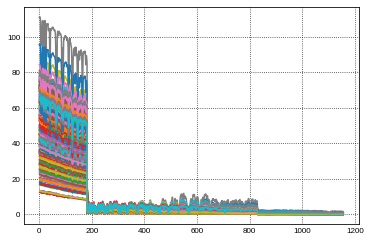

In [34]:
for i in range(500, 1000):
    plt.plot(test_Y[i])

In [11]:
print(index_X)
print(index_Y)

[[   0  713]
 [ 713 1578]
 [1578 2211]]
[[   0  183]
 [ 183  830]
 [ 830 1158]]


In [12]:
# from sklearn.decomposition import PCA
# X = np.concatenate((train_X, test_X), axis=0)
# model_pca = PCA()
# model_pca.fit(X)
# ratio_cumsm = np.cumsum(model_pca.explained_variance_ratio_)

# train_X_pca = model_pca.transform(train_X)
# test_X_pca = model_pca.transform(test_X)

In [13]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# n_all = list()
# mae_all = list()
# mse_all = list()

# for n in range(11, 211, 10):

#     train_X_pca_n = train_X_pca[:, :n]
#     test_X_pca_n = test_X_pca[:, :n]

# #     print(train_X_pca_n.shape, train_Y.shape)
# #     print(test_X_pca_n.shape, test_Y.shape)
#     lin_reg = LinearRegression()
#     lin_reg.fit(train_X_pca_n, train_Y)
#     predict_Y = lin_reg.predict(test_X_pca_n)

#     mae = mean_absolute_error(test_Y, predict_Y)
#     mse = mean_squared_error(test_Y, predict_Y)

#     n_all.append(n)
#     mae_all.append(mae)
#     mse_all.append(mse)

# n_all2 = list()
# mae_all2 = list()
# mse_all2 = list()
    
# for n in range(211, 2211+1, 200):

#     train_X_pca_n = train_X_pca[:, :n]
#     test_X_pca_n = test_X_pca[:, :n]

# #     print(train_X_pca_n.shape, train_Y.shape)
# #     print(test_X_pca_n.shape, test_Y.shape)
#     lin_reg = LinearRegression()
#     lin_reg.fit(train_X_pca_n, train_Y)
#     predict_Y = lin_reg.predict(test_X_pca_n)

#     mae = mean_absolute_error(test_Y, predict_Y)
#     mse = mean_squared_error(test_Y, predict_Y)

#     n_all2.append(n)
#     mae_all2.append(mae)
#     mse_all2.append(mse)

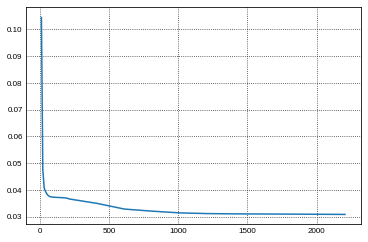

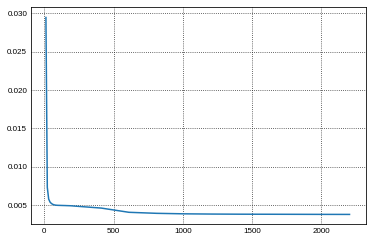

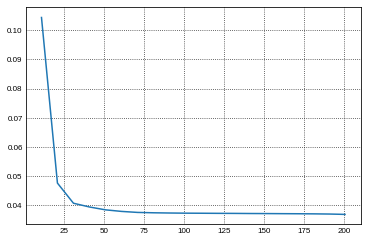

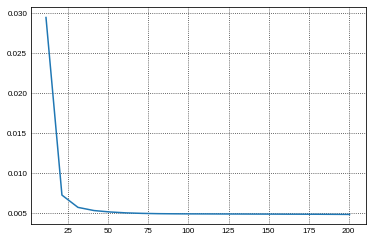

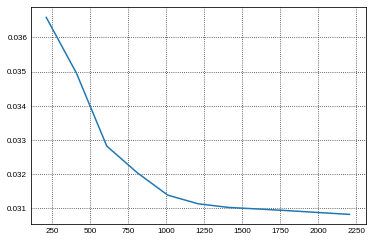

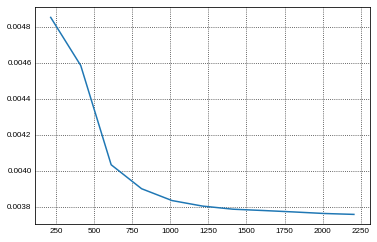

In [18]:
# result_dir = 'Result/' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i])
# if not os.path.isdir(result_dir):
#     os.mkdir(result_dir)

# file_name = result_dir + '/0000_mae_00.png'
# fig = plt.figure()
# plt.plot(n_all+n_all2, mae_all+mae_all2)
# plt.show()
# fig.savefig(file_name)
# file_name = result_dir + '/0000_mse_00.png'
# fig = plt.figure()
# plt.plot(n_all+n_all2, mse_all+mse_all2)
# plt.show()
# fig.savefig(file_name)
    
# file_name = result_dir + '/0000_mae_01.png'
# fig = plt.figure()
# plt.plot(n_all, mae_all)
# plt.show()
# fig.savefig(file_name)
# file_name = result_dir + '/0000_mse_01.png'
# fig = plt.figure()
# plt.plot(n_all, mse_all)
# plt.show()
# fig.savefig(file_name)

# file_name = result_dir + '/0000_mae_02.png'
# fig = plt.figure()
# plt.plot(n_all2, mae_all2)
# plt.show()
# fig.savefig(file_name)
# file_name = result_dir + '/0000_mse_02.png'
# fig = plt.figure()
# plt.plot(n_all2, mse_all2)
# plt.show()
# fig.savefig(file_name)

In [39]:
lin_reg = LinearRegression()
lin_reg.fit(train_X, train_Y)
predict_Y_linear = lin_reg.predict(test_X)

In [60]:
mae = mean_absolute_error(test_Y, predict_Y_linear)
mse = mean_squared_error(test_Y, predict_Y_linear)
print(mae)
print(mse)

0.030714322
0.003736776


In [47]:
# 去除预测结果中含无效值（<=0）的光谱
predict_Y_linear_tmp = predict_Y_linear.copy()
test_Y_linear_tmp = test_Y.copy()
predict_Y_linear_tmp = pd.DataFrame(predict_Y_linear_tmp)
test_Y_linear_tmp = pd.DataFrame(test_Y_linear_tmp)
print(predict_Y_linear_tmp.shape)
print(test_Y_linear_tmp.shape)
index = predict_Y_linear_tmp <=0
predict_Y_linear_tmp[index] = np.nan
test_Y_linear_tmp[index] = np.nan
predict_Y_linear_tmp = predict_Y_linear_tmp.dropna(axis=0)
test_Y_linear_tmp = test_Y_linear_tmp.dropna(axis=0)
print(predict_Y_linear_tmp.shape)
print(test_Y_linear_tmp.shape)

predict_Y_linear_tmp = np.array(predict_Y_linear_tmp)
test_Y_linear_tmp = np.array(test_Y_linear_tmp)

(605416, 1158)
(605416, 1158)
(605401, 1158)
(605401, 1158)


In [74]:
def plot_model_validate(tbb_test, tbb_predict, wavenumber, index, out_file):
    """
    对模型结果进行验证
    """
    bias = tbb_predict - tbb_test

    bias_abs = np.abs(bias)
    
    style_path = STYLE_PATH
    style_file = os.path.join(style_path, 'plot_regression.mplstyle')
    plt.style.use(style_file)
    fig = plt.figure(figsize=(6.4, 3), dpi=120)
    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)
#     ax1 = plt.subplot2grid((4, 1), (0, 0))
#     ax2 = plt.subplot2grid((4, 1), (1, 0), sharex=ax1)
#     ax3 = plt.subplot2grid((4, 1), (2, 0), sharex=ax1)
#     ax4 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1)

    lw = 1

    for s, d in index:
        ax1.plot(wavenumber[s:d], bias.mean(axis=0)[s:d], lw=lw)
        ax1.set_ylim(-0.2, 0.2)
        ax1.set_ylabel('TBB Bias Mean $(K)$')
        ax2.plot(wavenumber[s:d], bias.std(axis=0)[s:d], lw=lw)
        ax2.set_ylim(0.0, 1)
        ax2.set_xlabel('Wavenumber $(cm^{-1})$')
        ax2.set_ylabel('TBB Bias Std $(K)$')
#         ax3.plot(wavenumber[s:d], bias_abs.mean(axis=0)[s:d], lw=lw)
#         ax3.set_ylim(-0.2, 0.2)
#         ax3.set_ylabel('Abs Bias Mean $(K)$')
#         ax4.plot(wavenumber[s:d], bias_abs.std(axis=0)[s:d], lw=lw)
#         ax4.set_ylim(0.0, 1)
#         ax4.set_xlabel('Wavenumber $(cm^{-1})$')
#         ax4.set_ylabel('Abs Bias Std $(K)$')
    # ##### 保存图片
    fig.savefig(out_file, dpi=100)
    plt.show()
    fig.clear()
    plt.close()
    print('>>> {}'.format(out_file))

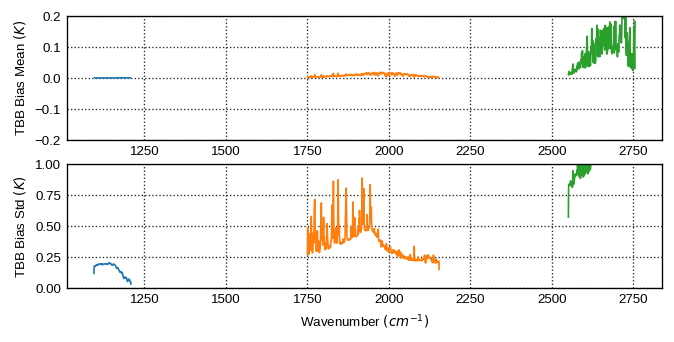

>>> Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/0000_650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0.png


In [75]:
out_file = '0000_' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '.png'

result_dir = 'Result/' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '_linear'
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

out_file = os.path.join(result_dir, out_file)
test_tbb = rad2tbb(test_Y_linear_tmp, wavenumber_Y)
predict_tbb = rad2tbb(predict_Y_linear_tmp, wavenumber_Y)

plot_model_validate(test_tbb, predict_tbb, wavenumber_Y, index_Y, out_file)

In [19]:
model_pca.components_.T.shape

(2211, 2211)

In [20]:
lin_reg.coef_.T.shape

(2211, 1158)

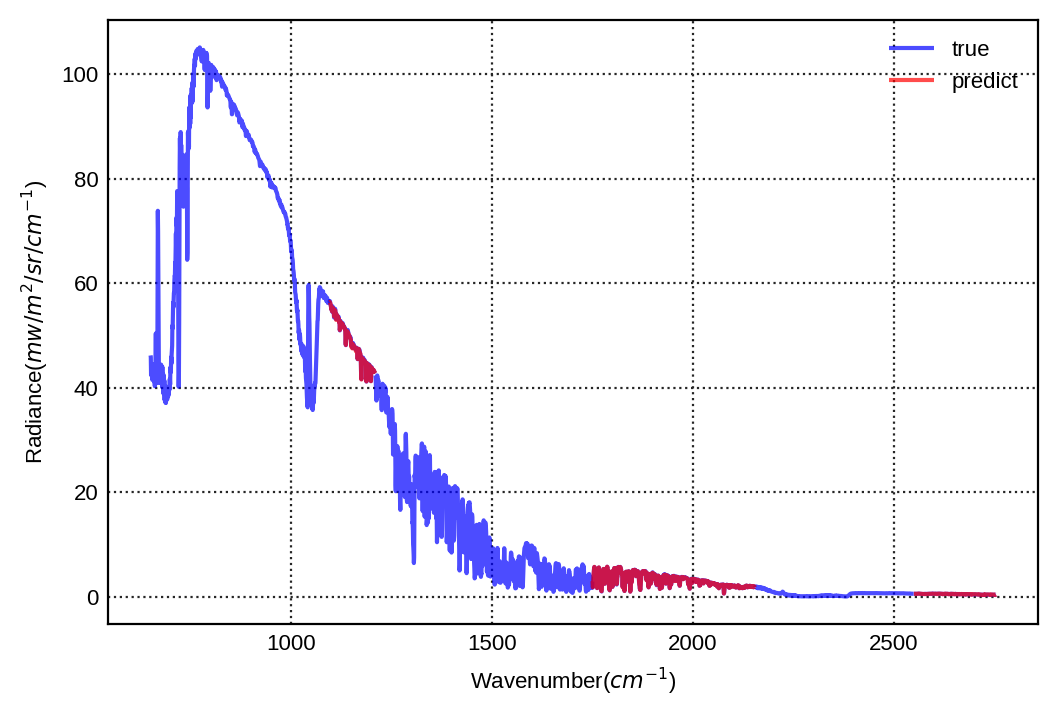

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0000_00.png


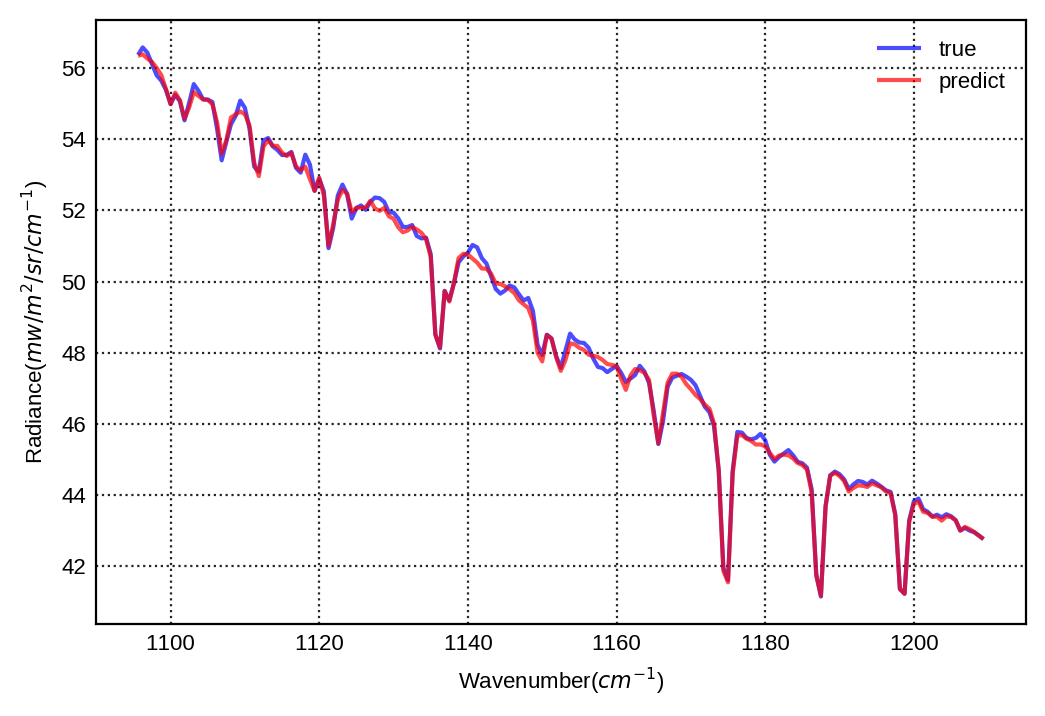

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0000_01.png


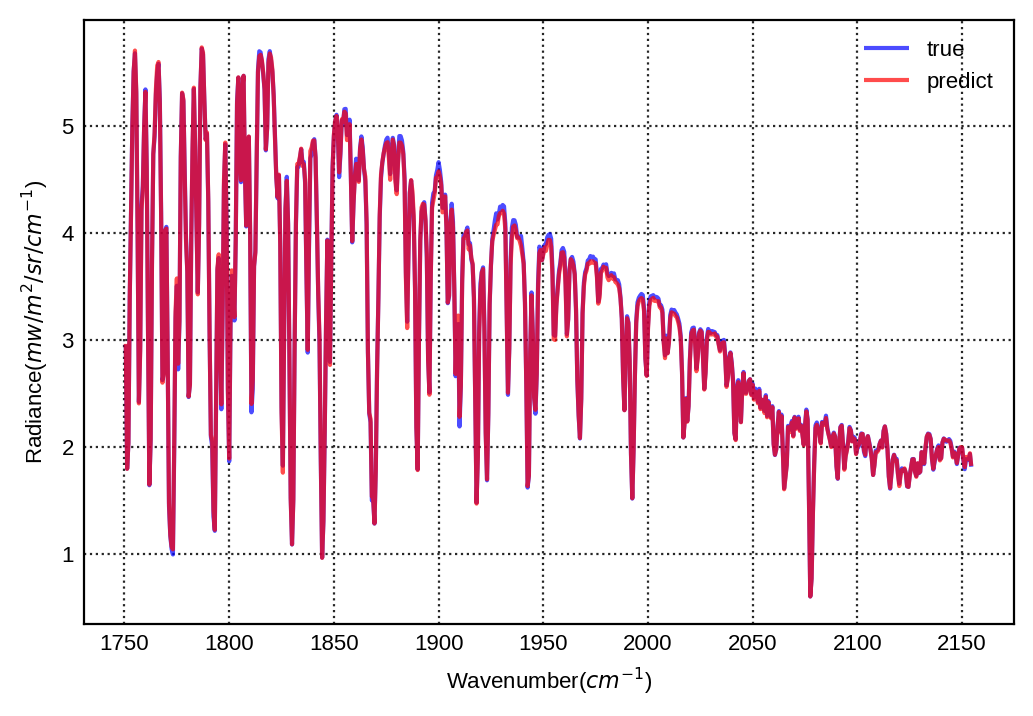

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0000_02.png


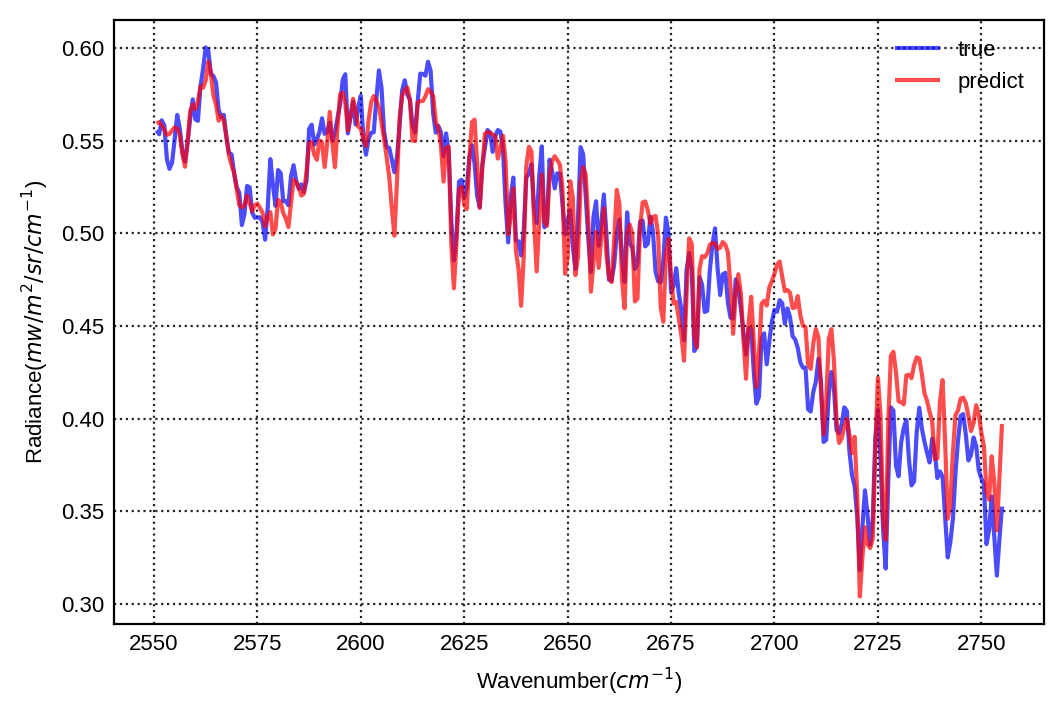

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0000_03.png


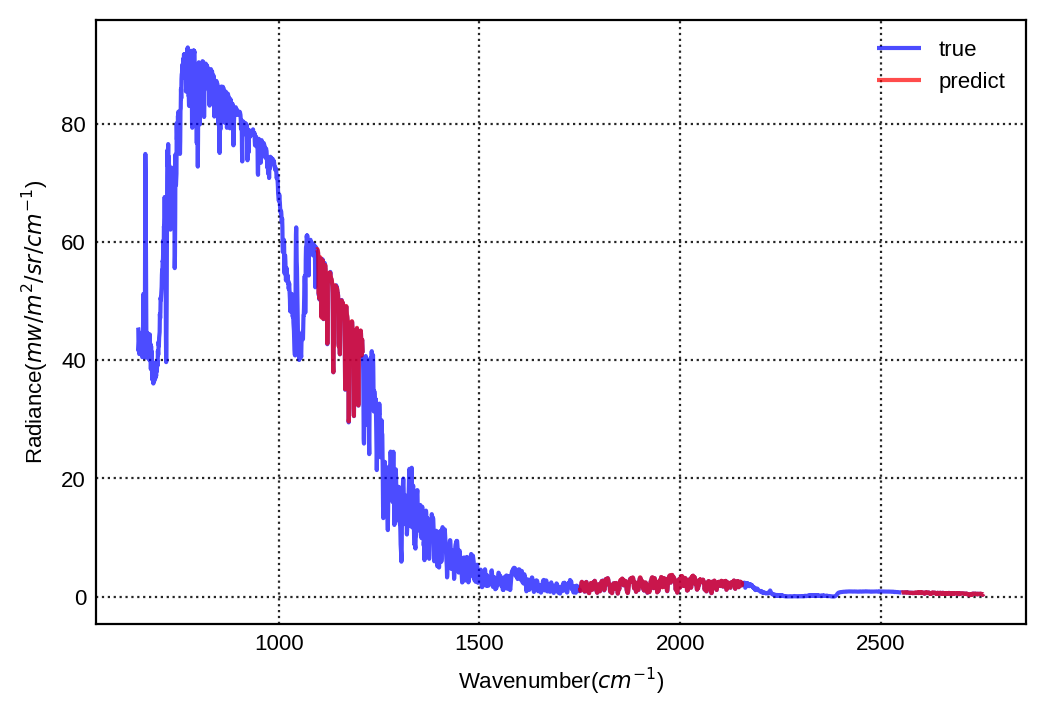

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0001_00.png


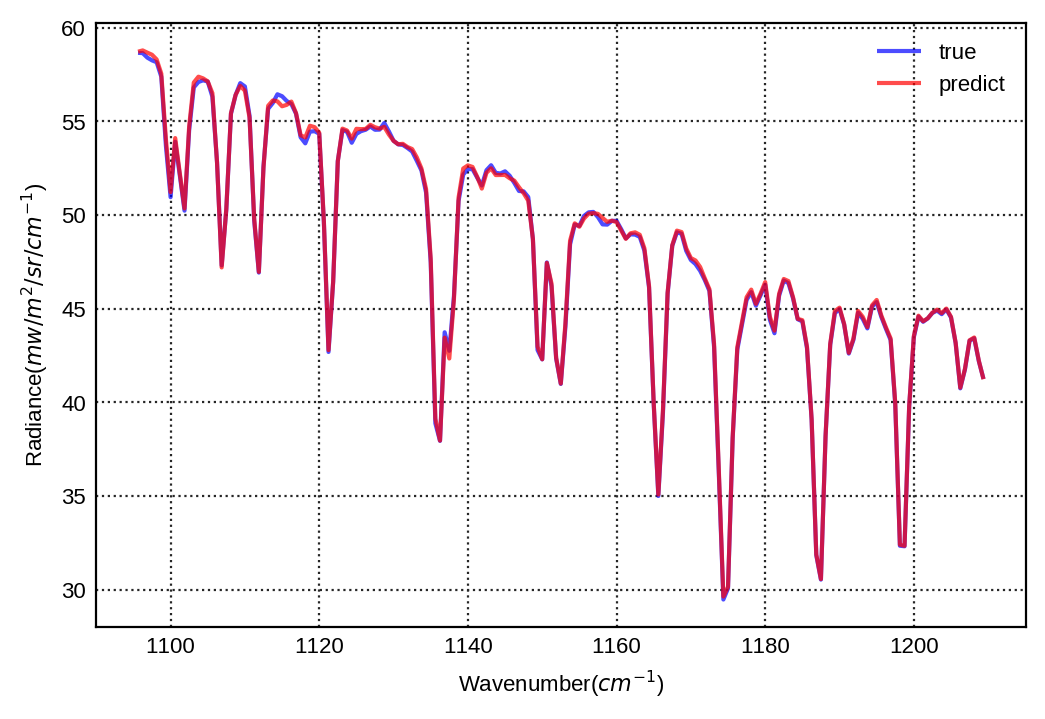

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0001_01.png


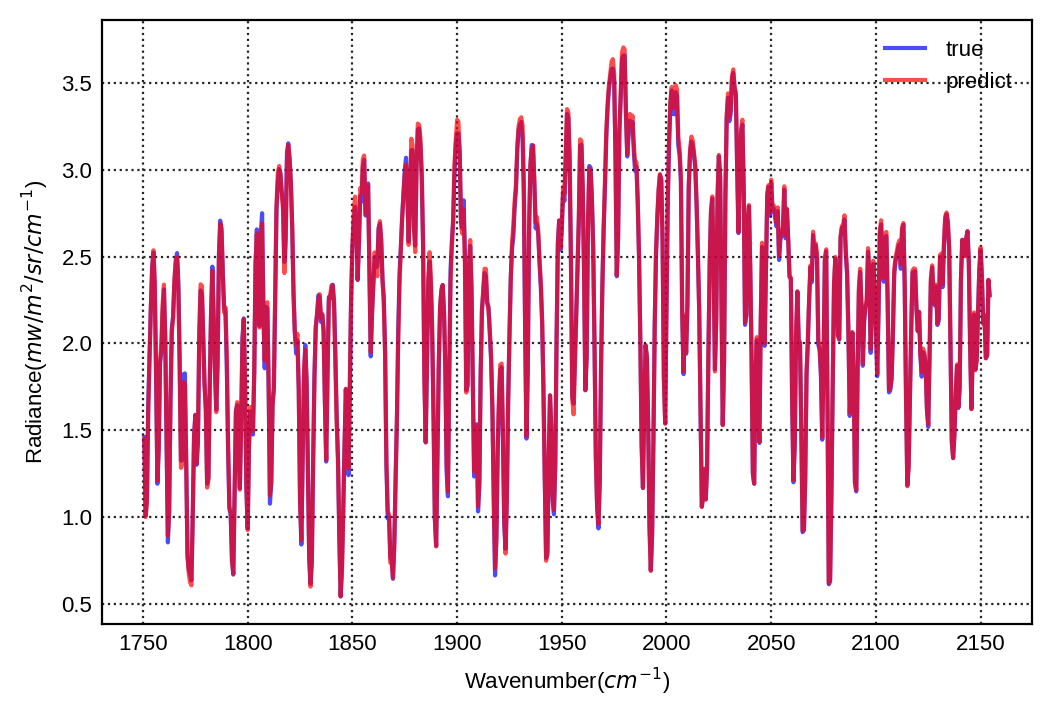

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0001_02.png


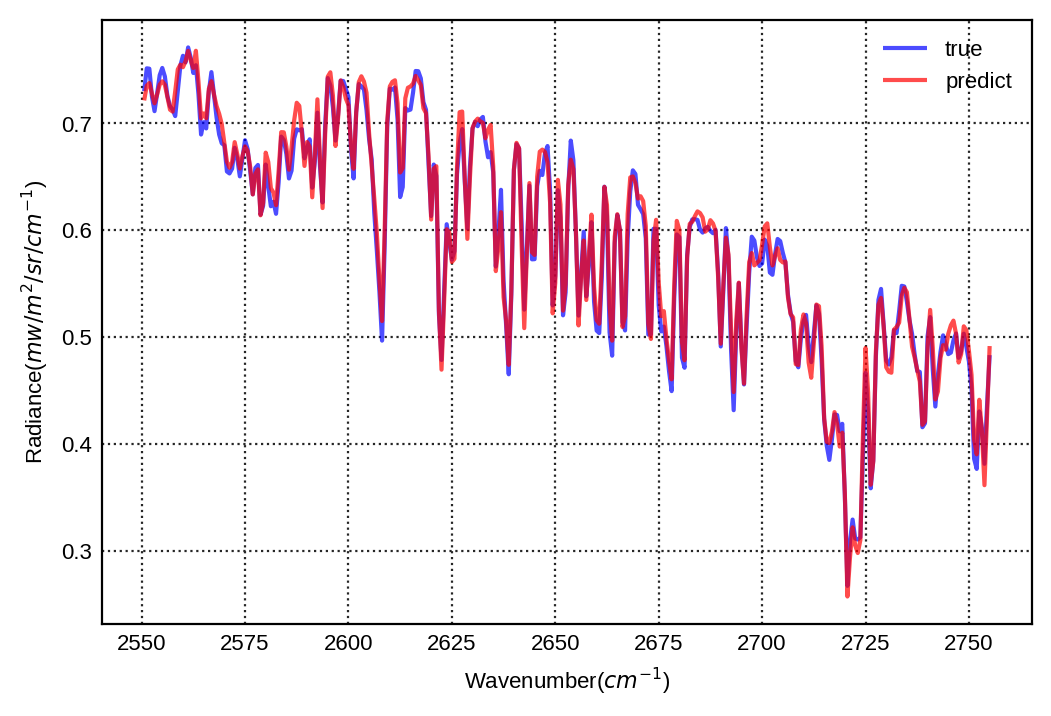

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0001_03.png


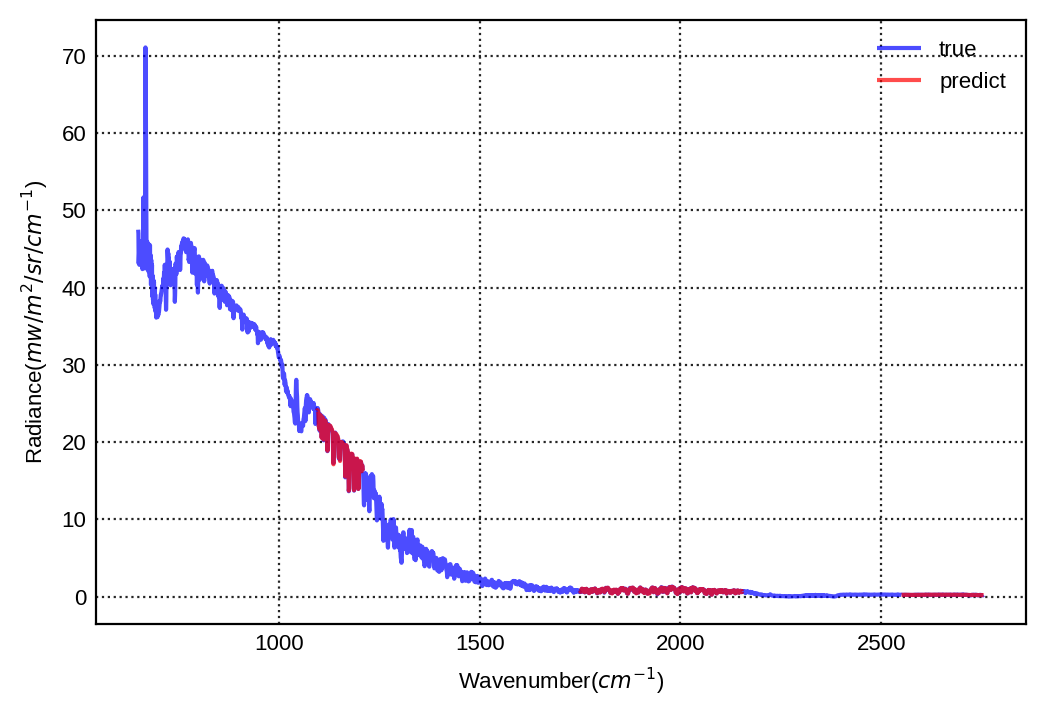

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0002_00.png


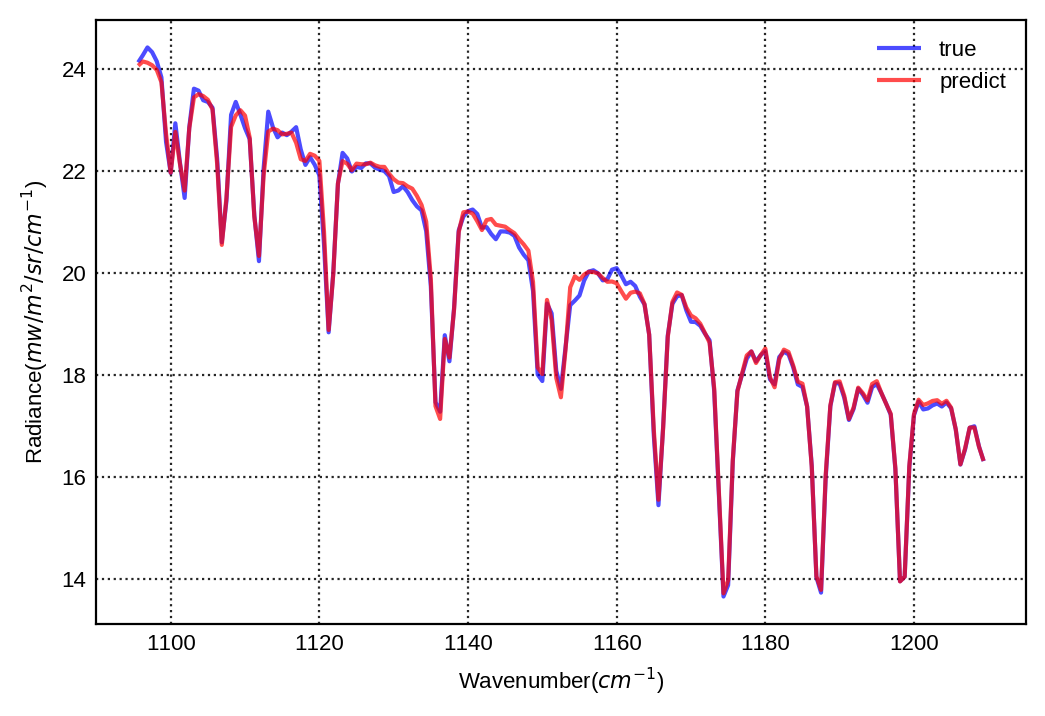

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0002_01.png


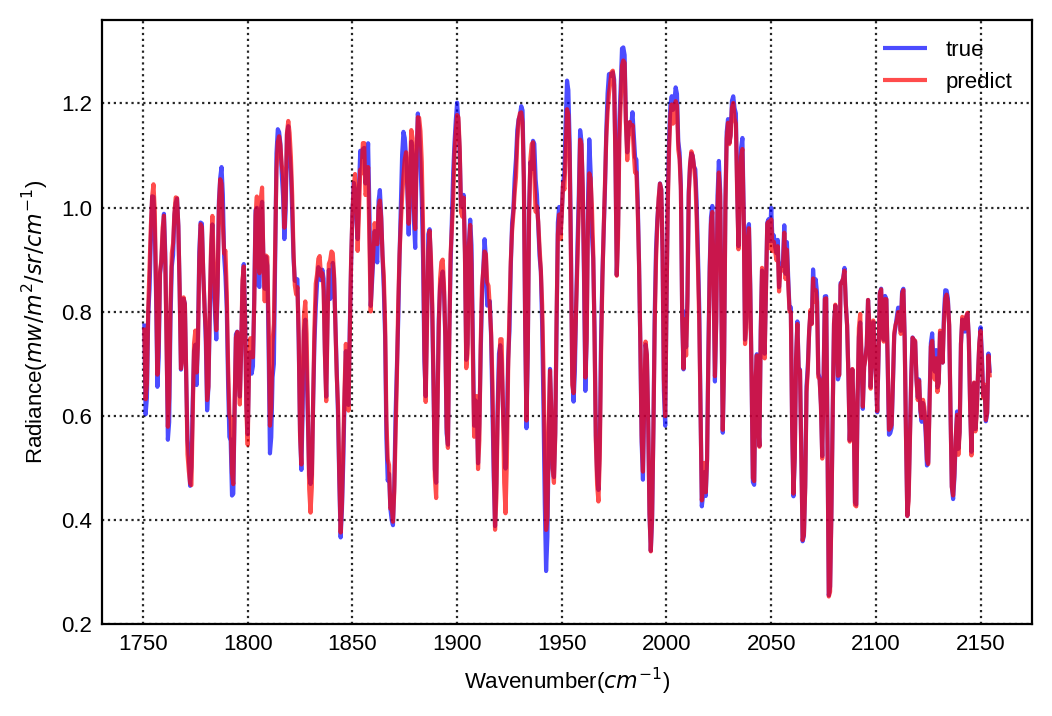

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0002_02.png


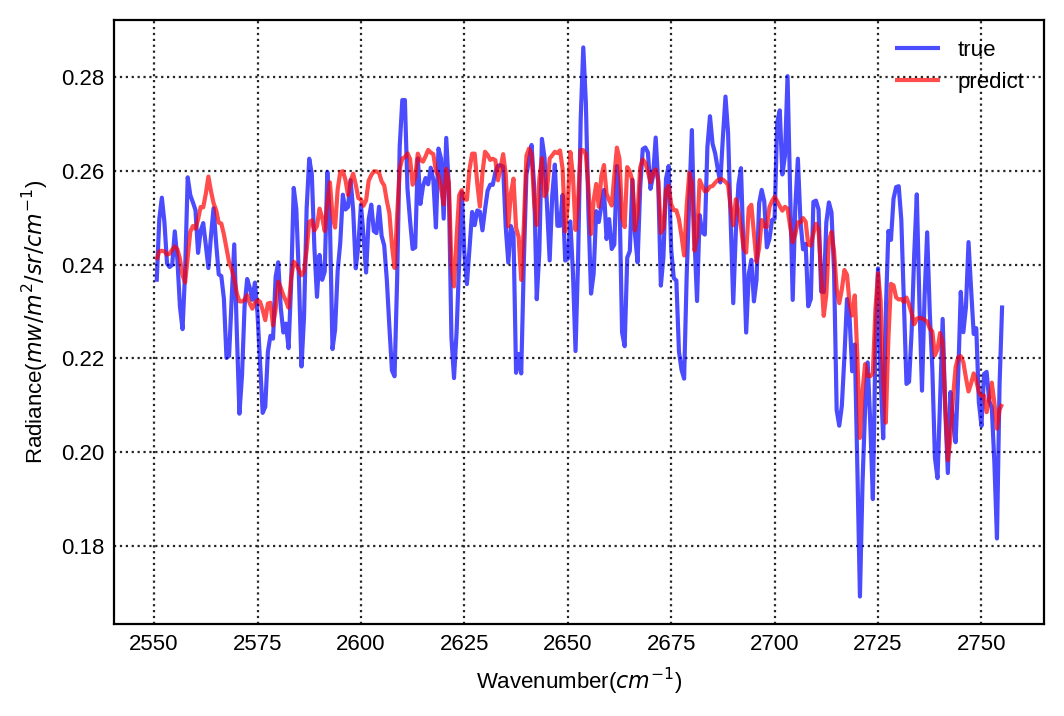

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0002_03.png


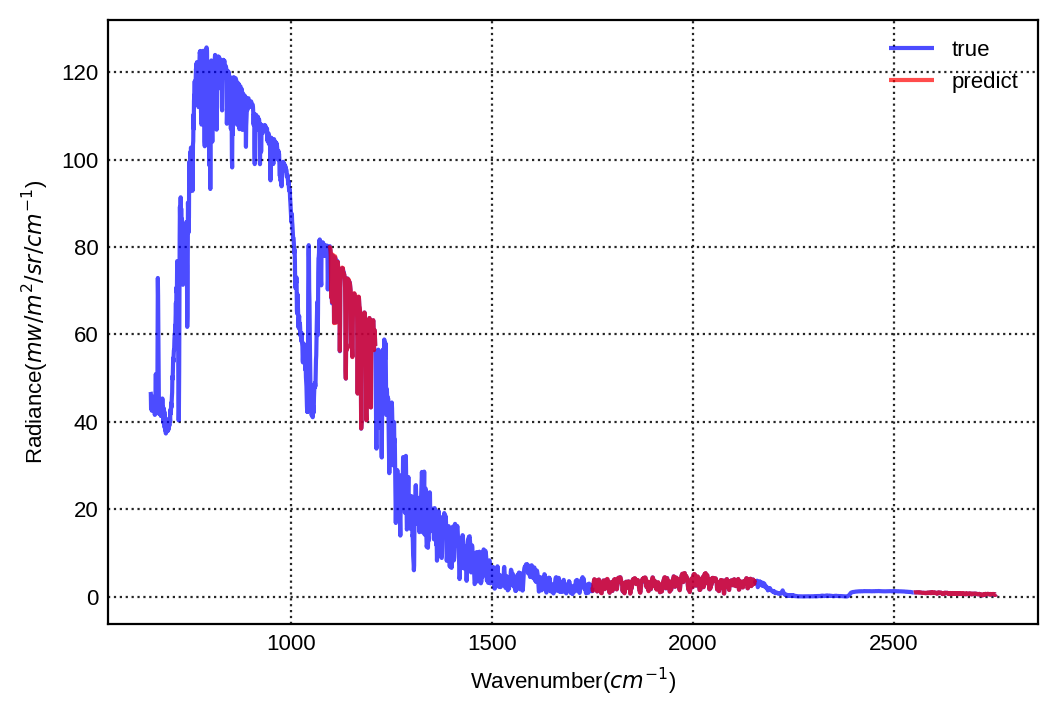

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0003_00.png


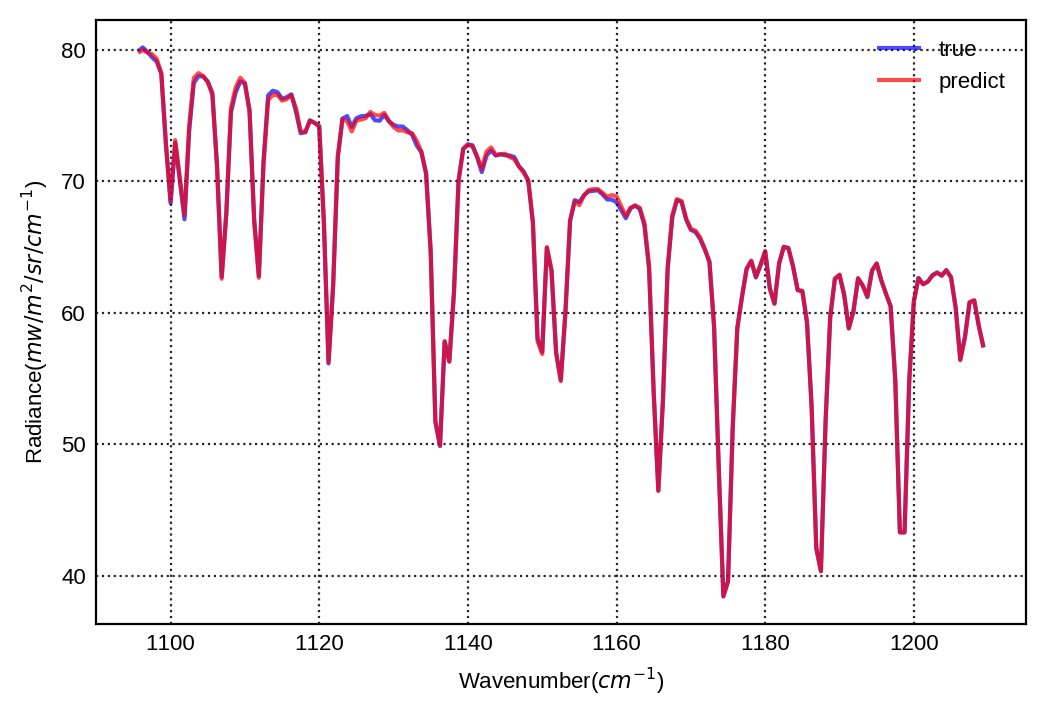

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0003_01.png


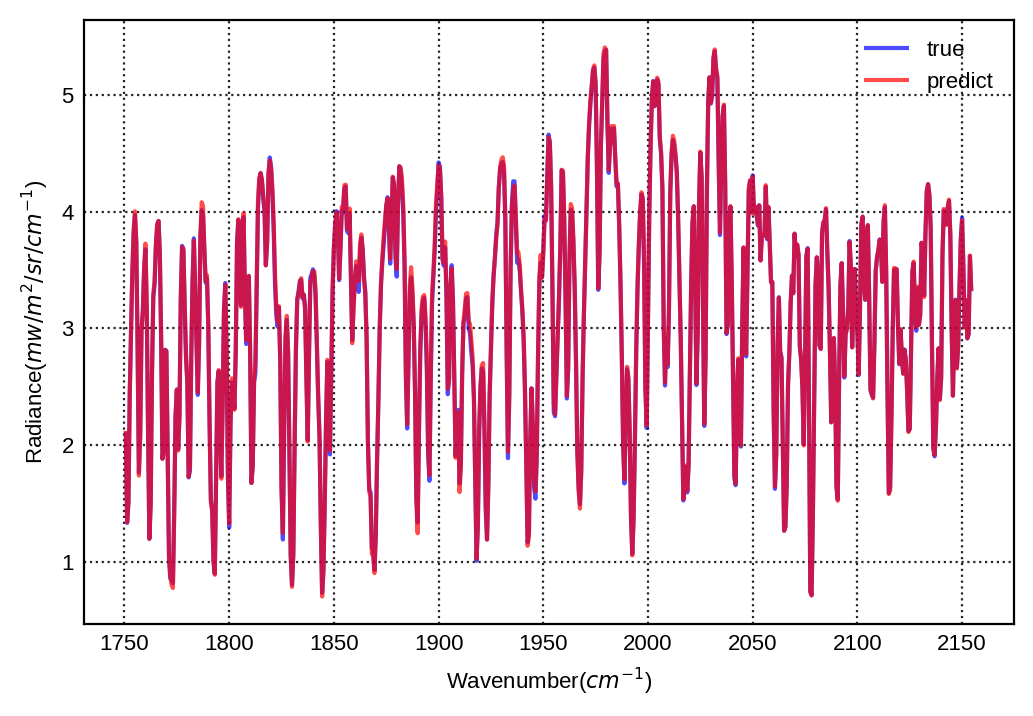

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0003_02.png


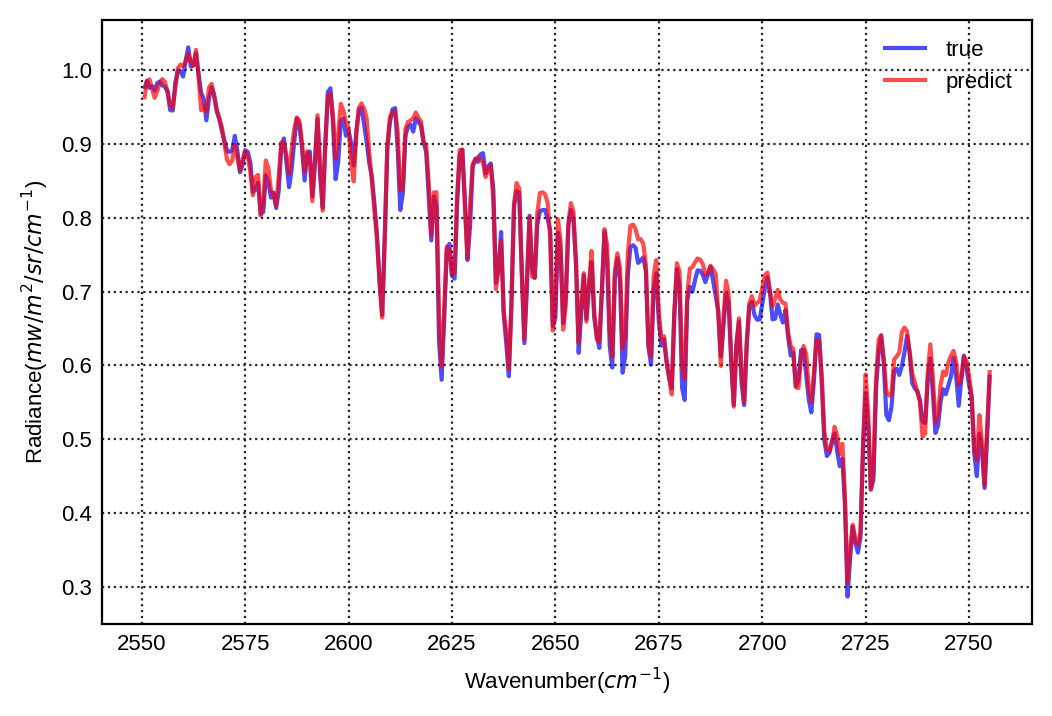

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0003_03.png


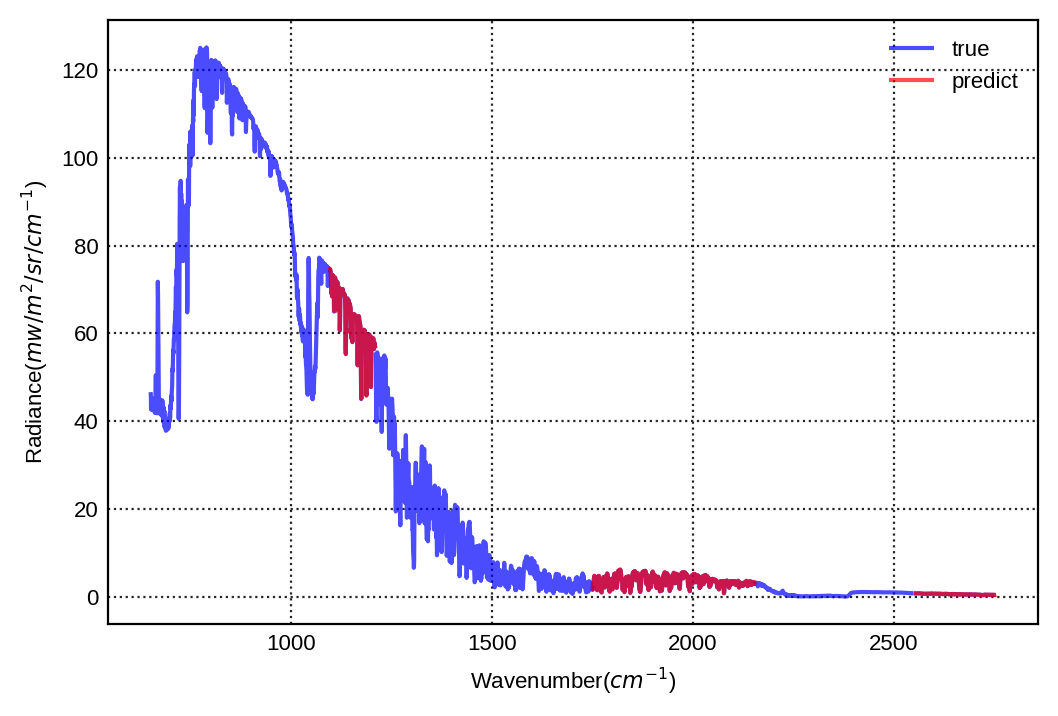

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0004_00.png


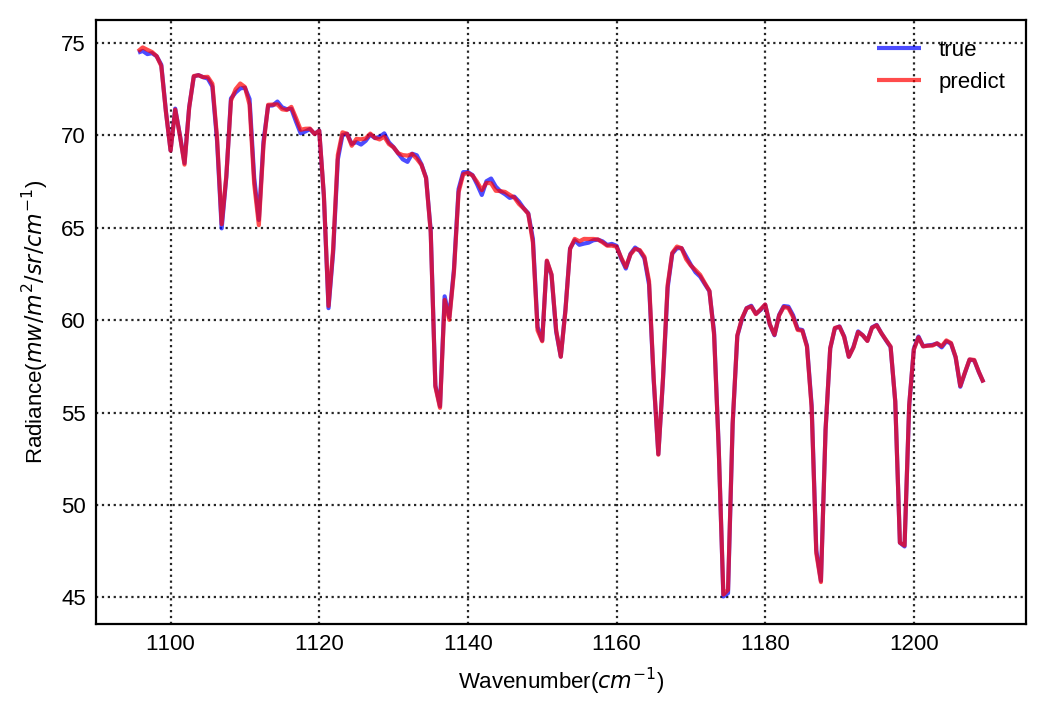

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0004_01.png


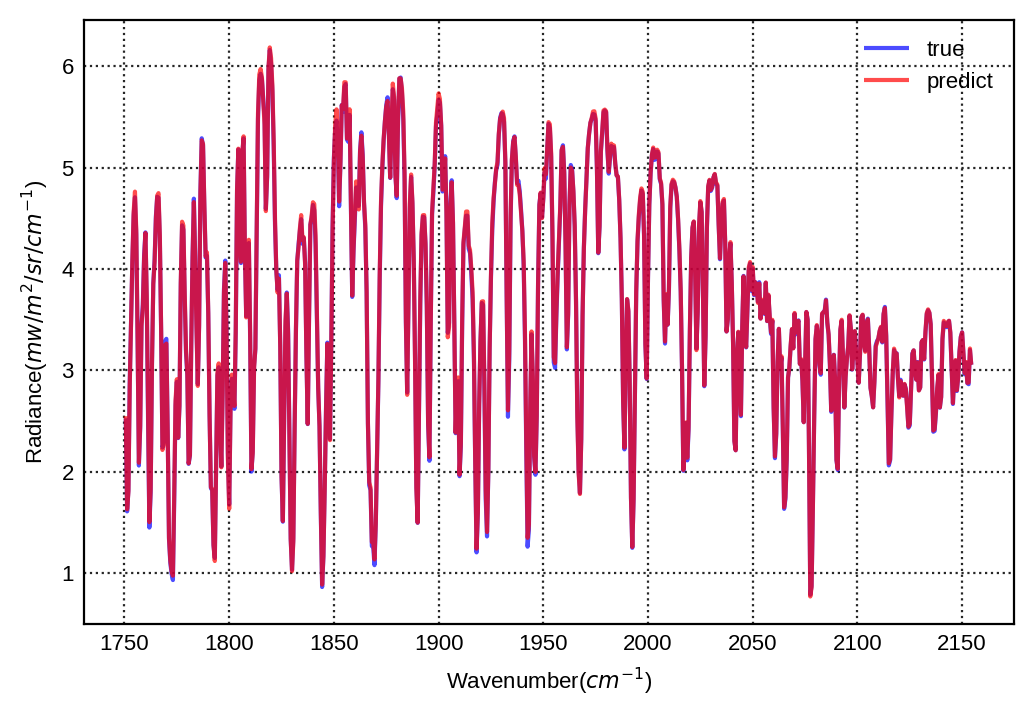

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0004_02.png


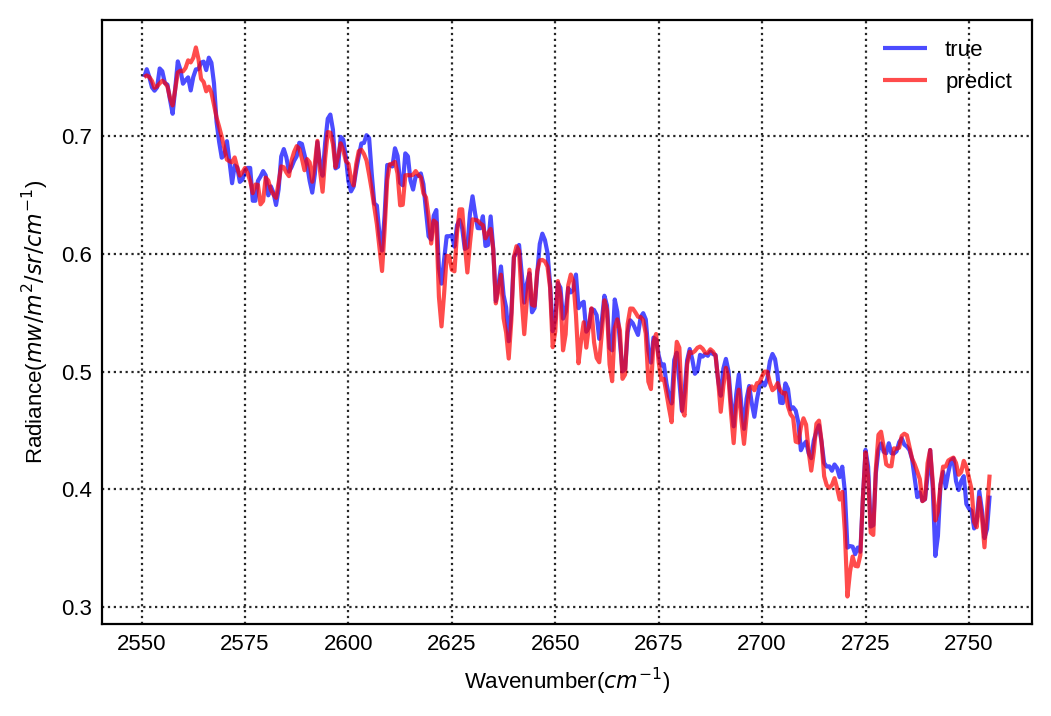

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_linear/s_0004_03.png


In [81]:
alpha = 0.7

result_dir = 'Result/' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '_linear'
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

file_name = result_dir + '/s_{:04d}_{:02d}.png'

for data_number in range(0, 5):
    count = 0
    fig = plt.figure(dpi=200)
    plot_true_label = False
    plot_predict_label = False
    for s, e in index_X:
        plt.plot(wavenumber_X[s: e], test_X[data_number][s: e], c='b', alpha=alpha)
    for s, e in index_Y:
        if plot_true_label:
            label=None
        else:
            label='true'
        plt.plot(wavenumber_Y[s: e], test_Y[data_number][s: e], c='b', alpha=alpha, label=label)
        plot_true_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict'
        plt.plot(wavenumber_Y[s: e], predict_Y_linear[data_number][s: e], c='r', alpha=alpha, label=label)
        plot_predict_label = True
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('Radiance($mw/m^2/sr/cm^{-1}$)')
    plt.legend()
    plt.show()
    fig.savefig(file_name.format(data_number, count), dpi=200)
    print(file_name.format(data_number, count))
    count += 1
    for s, e in index_Y:
        fig = plt.figure(dpi=200)
        plt.plot(wavenumber_Y[s: e], test_Y[data_number][s: e], c='b', alpha=alpha, label='true')
        plt.plot(wavenumber_Y[s: e], predict_Y_linear[data_number][s: e], c='r', alpha=alpha, label='predict')
        plt.xlabel('Wavenumber($cm^{-1}$)')
        plt.ylabel('Radiance($mw/m^2/sr/cm^{-1}$)')
        plt.legend()
        plt.show()
        fig.savefig(file_name.format(data_number, count), dpi=200)
        print(file_name.format(data_number, count))
        count += 1

In [51]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(2211, activation='elu', input_shape=(2211,)))
    model.add(layers.Dense(2211, activation='elu'))
    model.add(layers.Dense(2211, activation='elu'))
    model.add(layers.Dense(1158))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model
model = build_model()
print(model.summary())

num_epochs = 100
batch_size = 1024
history = model.fit(train_X, train_Y, epochs=num_epochs, batch_size=batch_size, validation_data=(test_X, test_Y))


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2211)              4890732   
_________________________________________________________________
dense_2 (Dense)              (None, 2211)              4890732   
_________________________________________________________________
dense_3 (Dense)              (None, 2211)              4890732   
_________________________________________________________________
dense_4 (Dense)              (None, 1158)              2561496   
Total params: 17,233,692
Trainable params: 17,233,692
Non-trainable params: 0
_________________________________________________________________
None
Train on 2421661 samples, validate on 605416 samples
Epoch 1/100
2421661/2421661 [==============================] - 150s 62us/step - loss: 1.2283 - mean_absolute_error: 0.3267 - val_loss: 0.2385 - val_mean_absolute_error: 0.2686
Epoch 2/100
2421661/2421661 

2421661/2421661 [==============================] - 141s 58us/step - loss: 0.0193 - mean_absolute_error: 0.0929 - val_loss: 0.0233 - val_mean_absolute_error: 0.0990
Epoch 43/100
2421661/2421661 [==============================] - 142s 58us/step - loss: 0.0193 - mean_absolute_error: 0.0924 - val_loss: 0.0227 - val_mean_absolute_error: 0.1109
Epoch 44/100
2421661/2421661 [==============================] - 141s 58us/step - loss: 0.0191 - mean_absolute_error: 0.0921 - val_loss: 0.0380 - val_mean_absolute_error: 0.1671
Epoch 45/100
2421661/2421661 [==============================] - 141s 58us/step - loss: 0.0190 - mean_absolute_error: 0.0917 - val_loss: 0.0226 - val_mean_absolute_error: 0.1139
Epoch 46/100
2421661/2421661 [==============================] - 141s 58us/step - loss: 0.0188 - mean_absolute_error: 0.0920 - val_loss: 0.0350 - val_mean_absolute_error: 0.1222
Epoch 47/100
2421661/2421661 [==============================] - 141s 58us/step - loss: 0.0188 - mean_absolute_error: 0.0915 - va

2421661/2421661 [==============================] - 141s 58us/step - loss: 0.0161 - mean_absolute_error: 0.0864 - val_loss: 0.0113 - val_mean_absolute_error: 0.0763
Epoch 89/100
2421661/2421661 [==============================] - 141s 58us/step - loss: 0.0158 - mean_absolute_error: 0.0858 - val_loss: 0.0199 - val_mean_absolute_error: 0.1037
Epoch 90/100
2421661/2421661 [==============================] - 141s 58us/step - loss: 0.0161 - mean_absolute_error: 0.0860 - val_loss: 0.0082 - val_mean_absolute_error: 0.0556
Epoch 91/100
2421661/2421661 [==============================] - 141s 58us/step - loss: 0.0160 - mean_absolute_error: 0.0861 - val_loss: 0.0343 - val_mean_absolute_error: 0.1166
Epoch 92/100
2421661/2421661 [==============================] - 141s 58us/step - loss: 0.0158 - mean_absolute_error: 0.0844 - val_loss: 0.0144 - val_mean_absolute_error: 0.0795
Epoch 93/100
2421661/2421661 [==============================] - 141s 58us/step - loss: 0.0158 - mean_absolute_error: 0.0854 - va

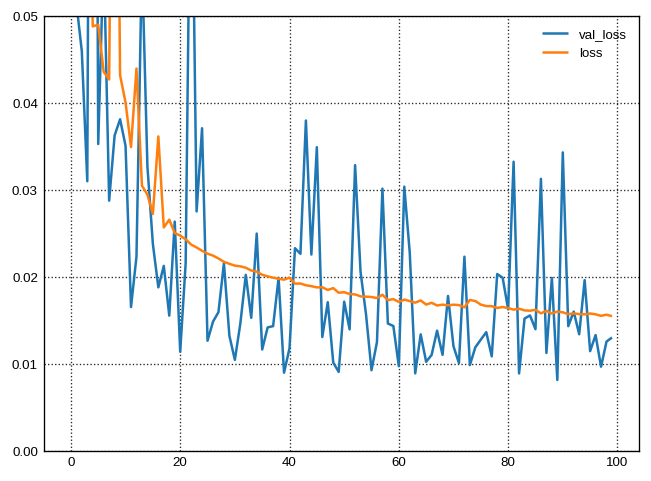

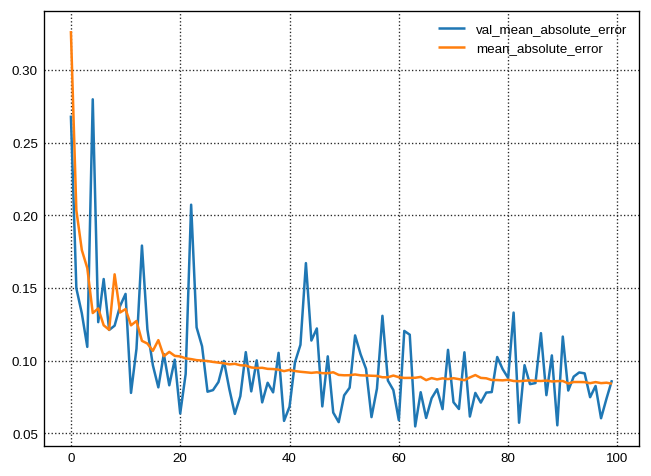

In [59]:
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.ylim(0, 0.05)
plt.legend()
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
plt.legend()

In [53]:
predict_Y_dnn = model.predict(test_X)

In [54]:
mae = mean_absolute_error(test_Y, predict_Y_dnn)
mse = mean_squared_error(test_Y, predict_Y_dnn)
print(mae)
print(mse)

0.08662245
0.013066167


In [55]:
# 去除预测结果中含无效值（<=0）的光谱
predict_Y_dnn_tmp = predict_Y_dnn.copy()
test_Y_dnn_tmp = test_Y.copy()
predict_Y_dnn_tmp = pd.DataFrame(predict_Y_dnn_tmp)
test_Y_dnn_tmp = pd.DataFrame(test_Y_dnn_tmp)
print(predict_Y_dnn_tmp.shape)
print(test_Y_dnn_tmp.shape)
index = predict_Y_dnn_tmp <=0
predict_Y_dnn_tmp[index] = np.nan
test_Y_dnn_tmp[index] = np.nan
predict_Y_dnn_tmp = predict_Y_dnn_tmp.dropna(axis=0)
test_Y_dnn_tmp = test_Y_dnn_tmp.dropna(axis=0)
print(predict_Y_dnn_tmp.shape)
print(test_Y_dnn_tmp.shape)

predict_Y_dnn_tmp = np.array(predict_Y_dnn_tmp)
test_Y_dnn_tmp = np.array(test_Y_dnn_tmp)

(605416, 1158)
(605416, 1158)
(528876, 1158)
(528876, 1158)


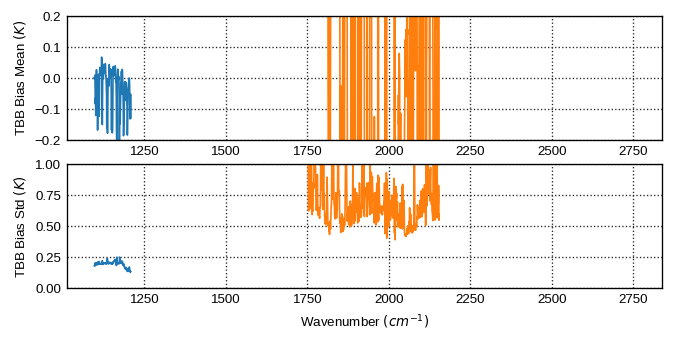

>>> Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/0000_650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn.png


In [79]:
out_file = '0000_' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + "_dnn" + '.png'

result_dir = 'Result/' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + "_dnn"
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

out_file = os.path.join(result_dir, out_file)
test_tbb = rad2tbb(test_Y_dnn_tmp, wavenumber_Y)
predict_tbb = rad2tbb(predict_Y_dnn_tmp, wavenumber_Y)

plot_model_validate(test_tbb, predict_tbb, wavenumber_Y, index_Y, out_file)

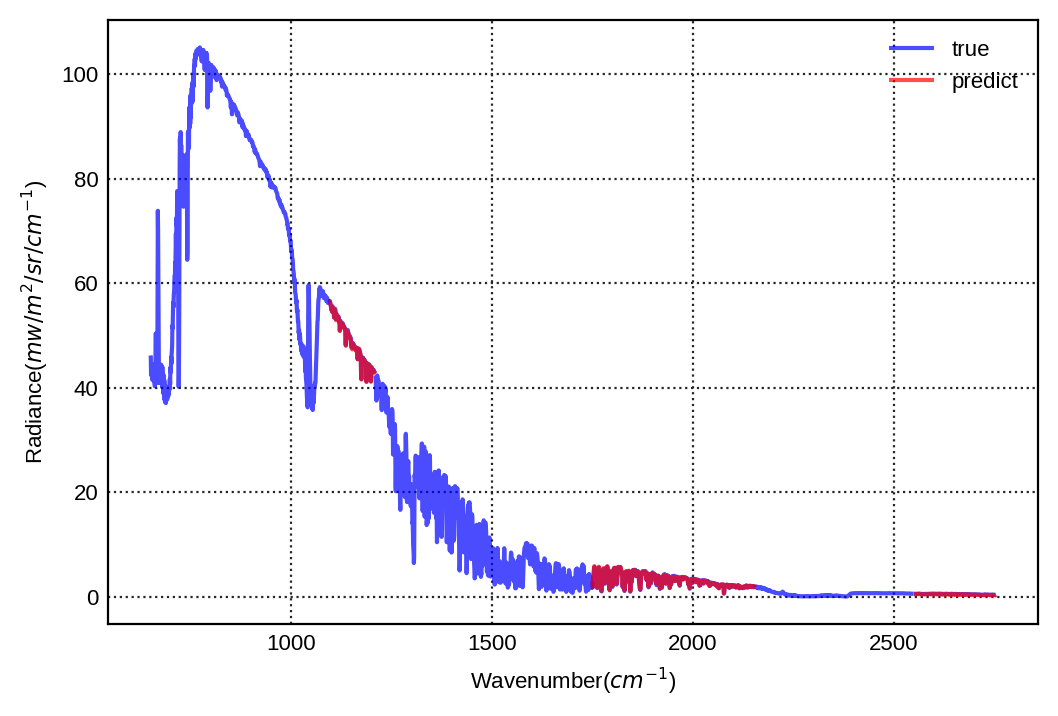

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0000_00.png


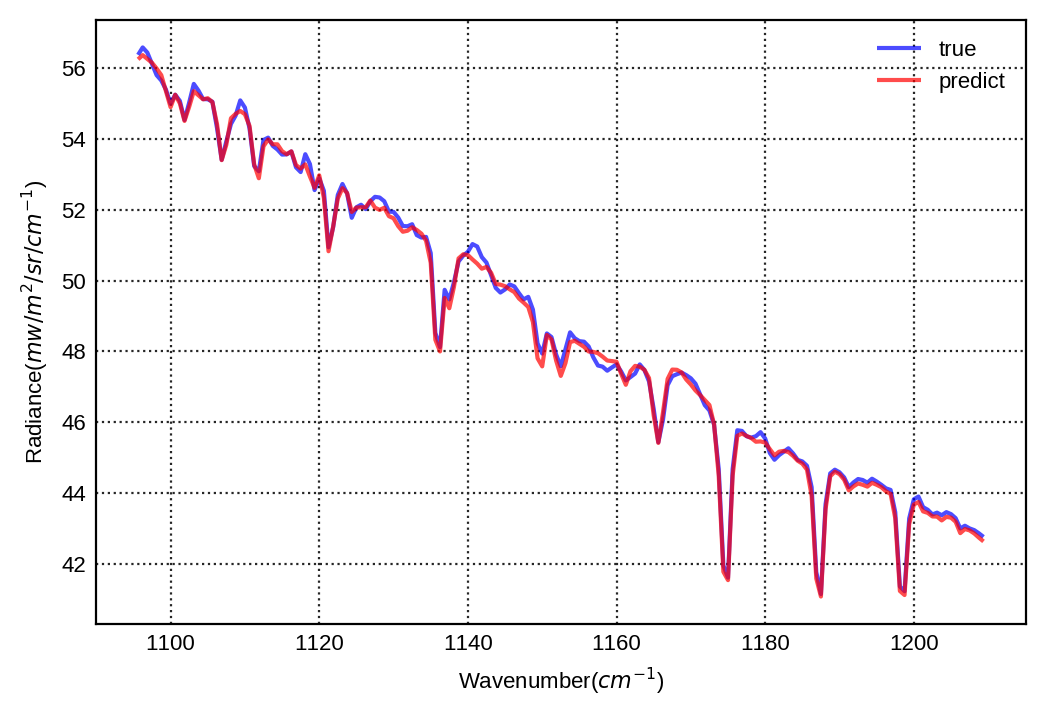

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0000_01.png


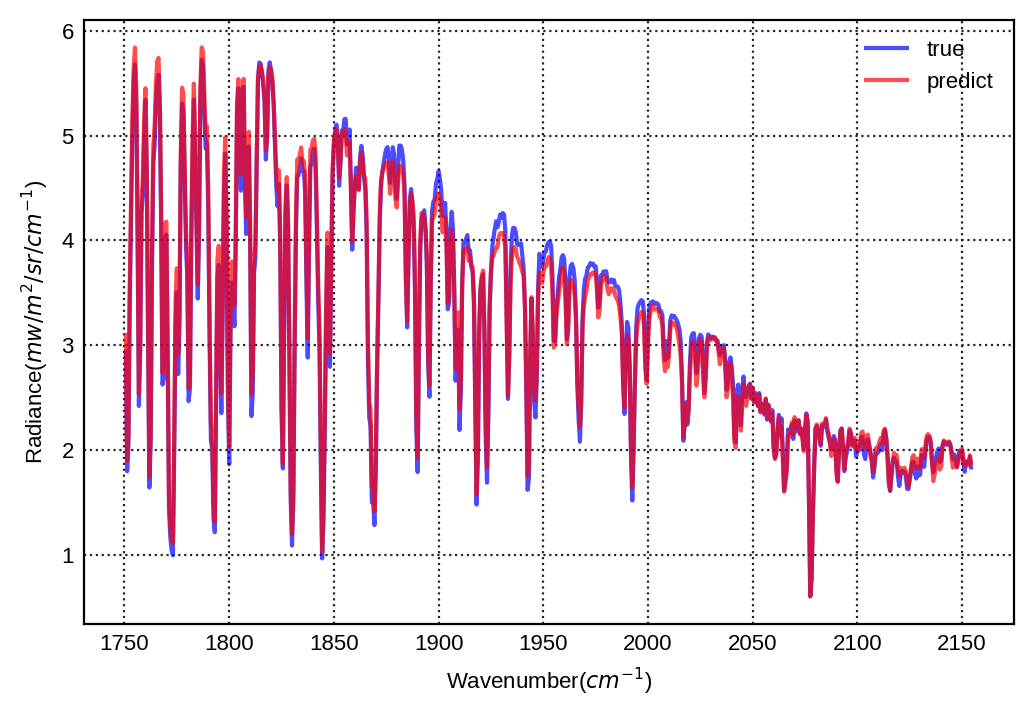

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0000_02.png


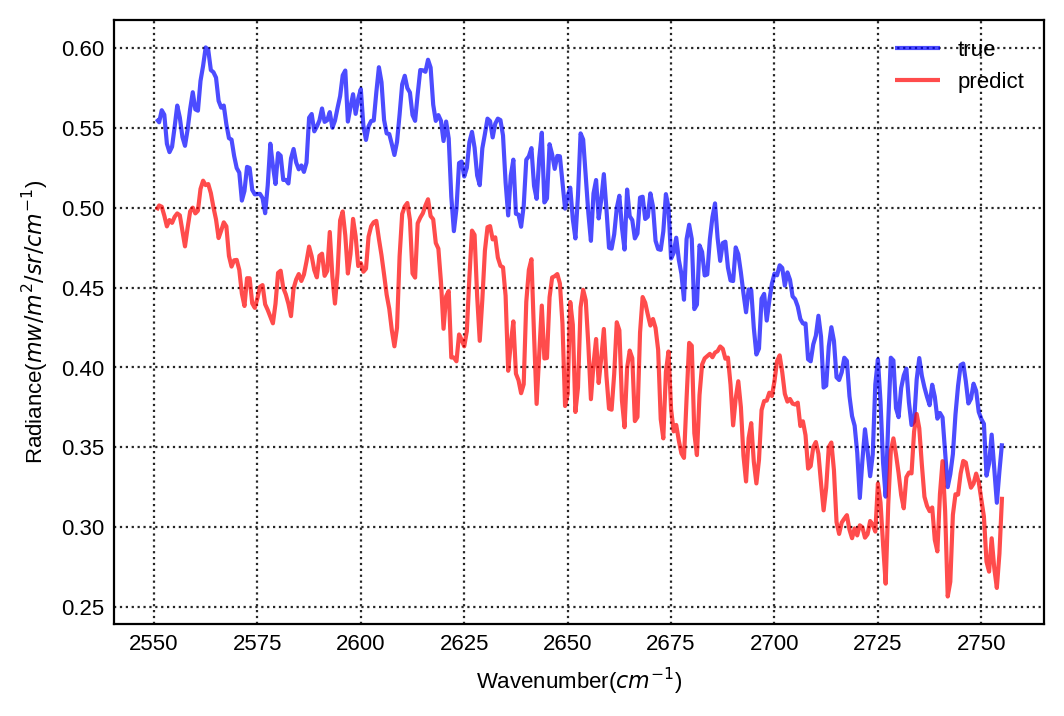

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0000_03.png


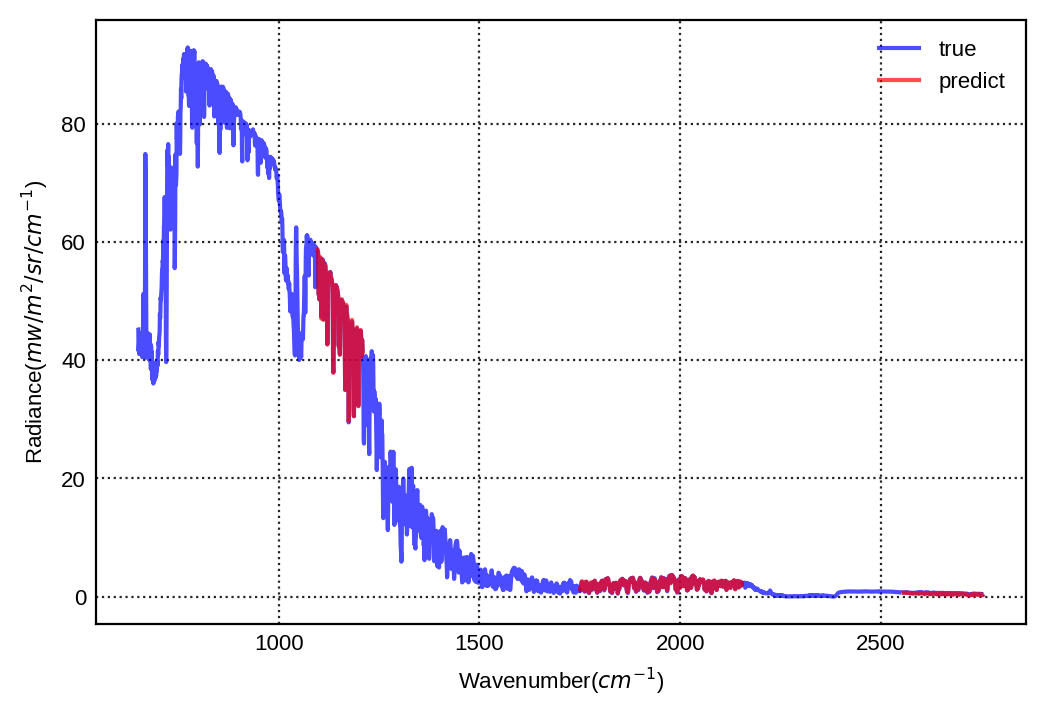

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0001_00.png


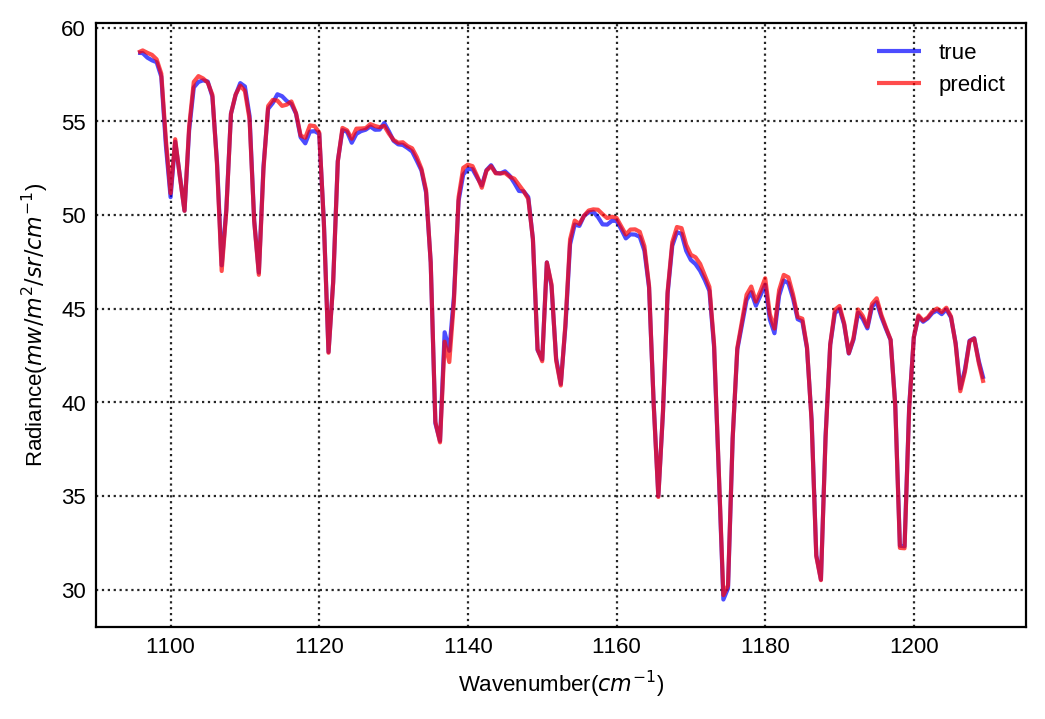

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0001_01.png


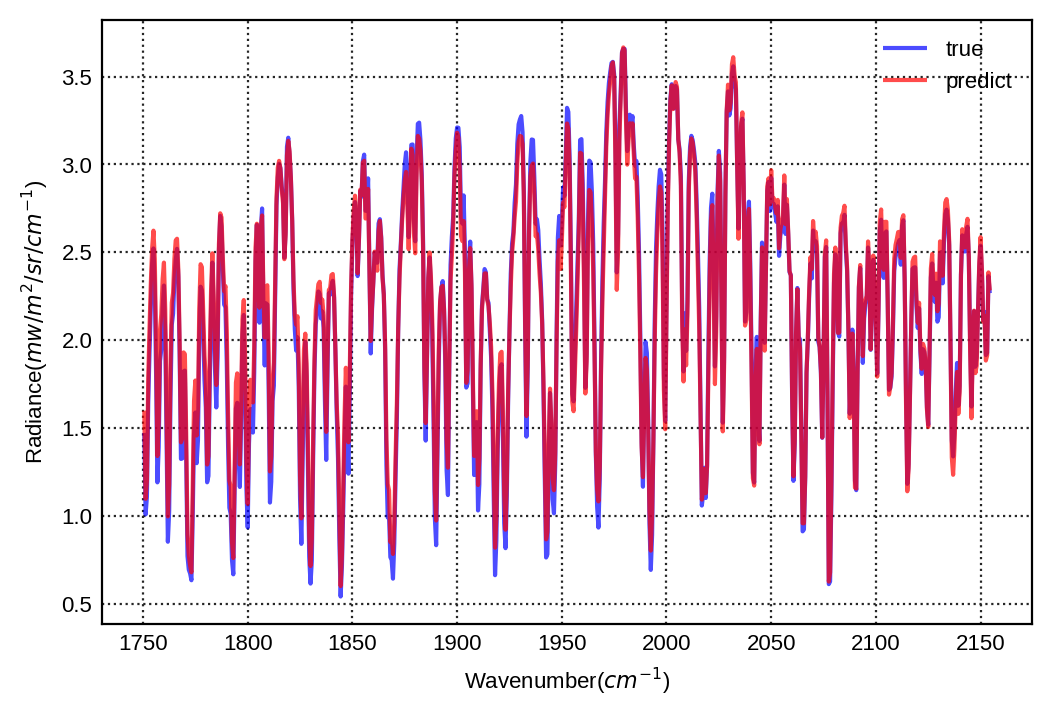

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0001_02.png


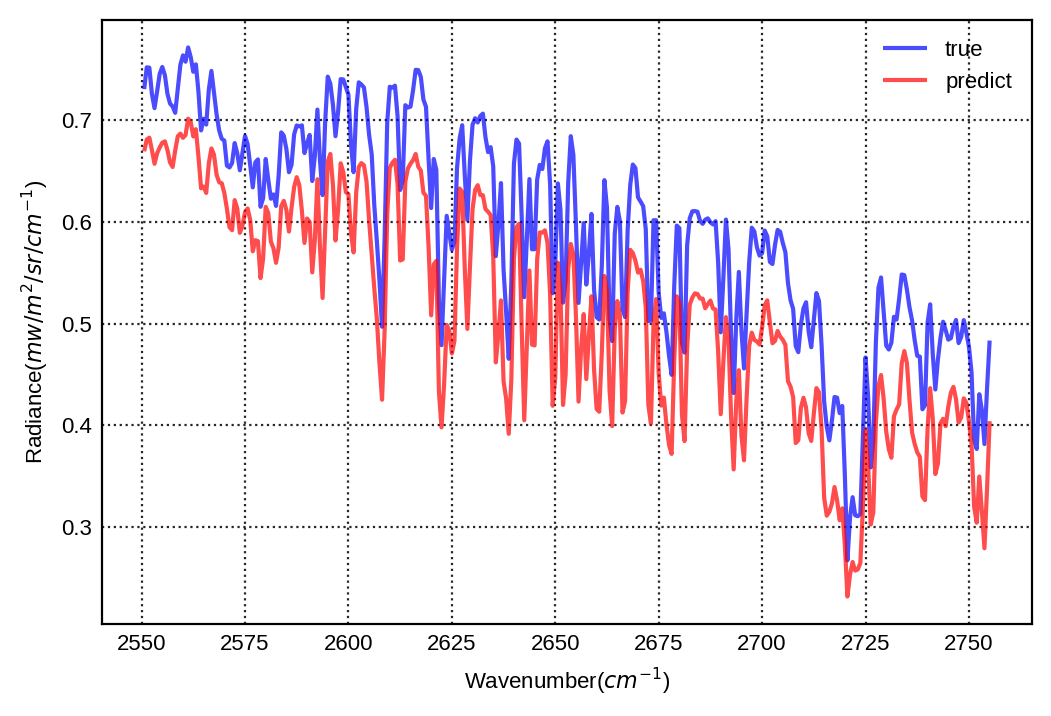

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0001_03.png


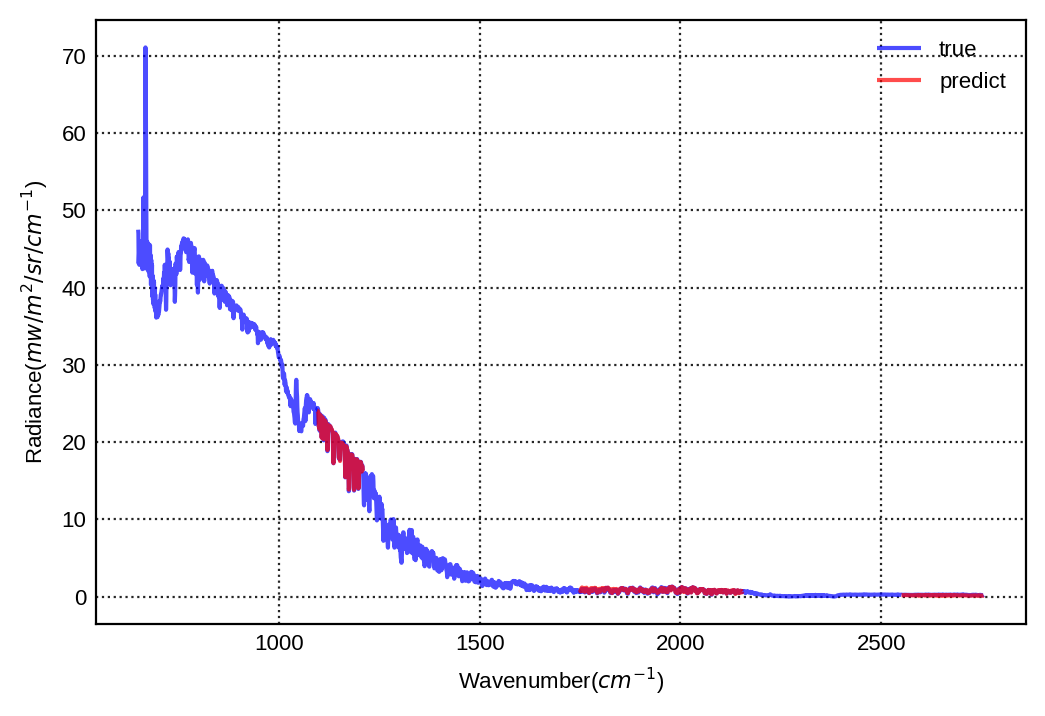

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0002_00.png


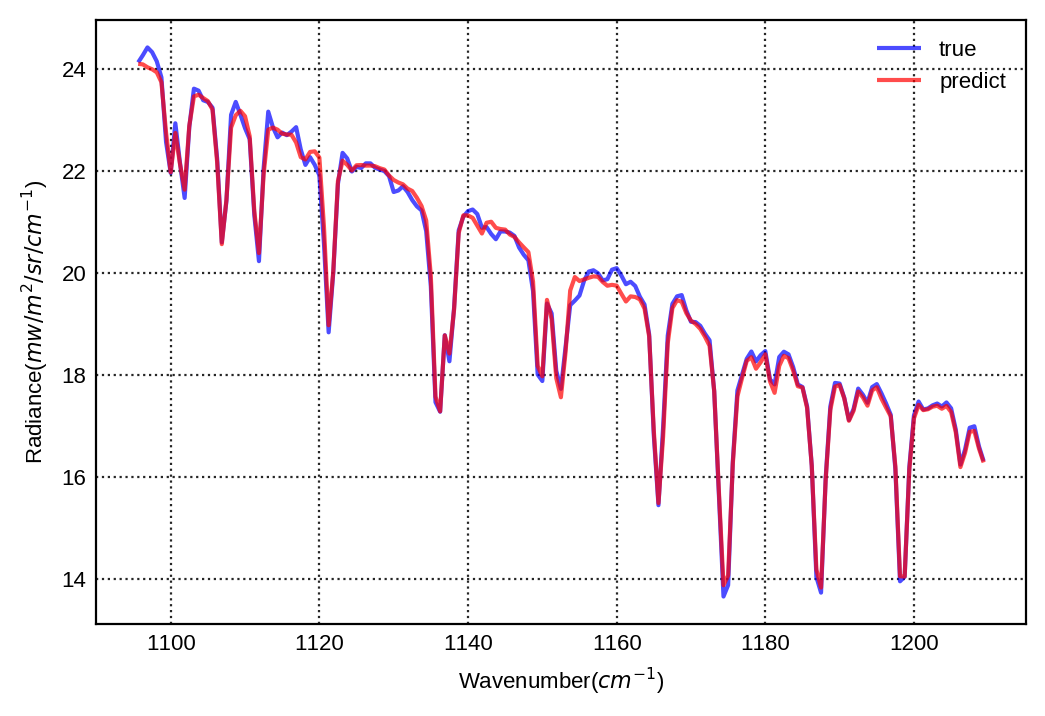

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0002_01.png


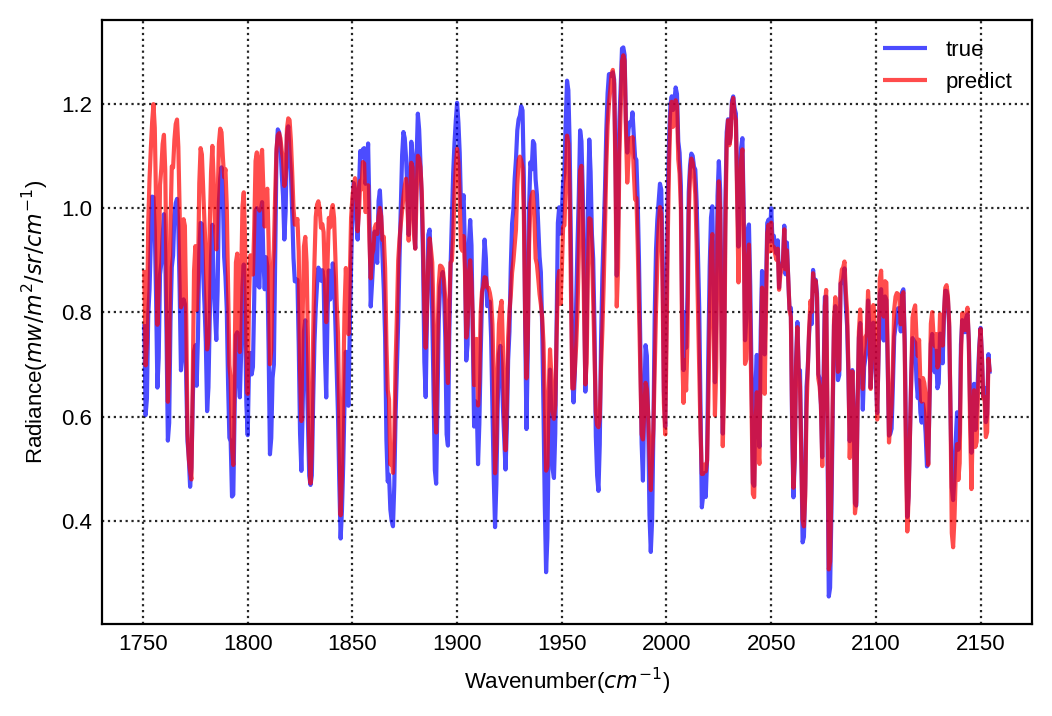

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0002_02.png


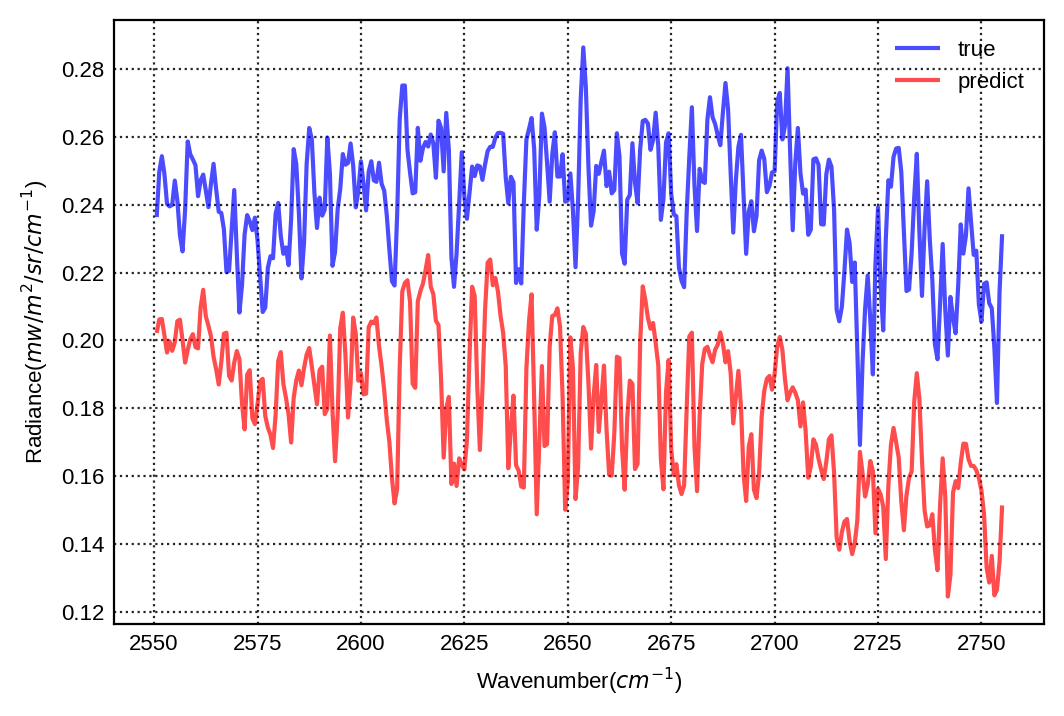

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0002_03.png


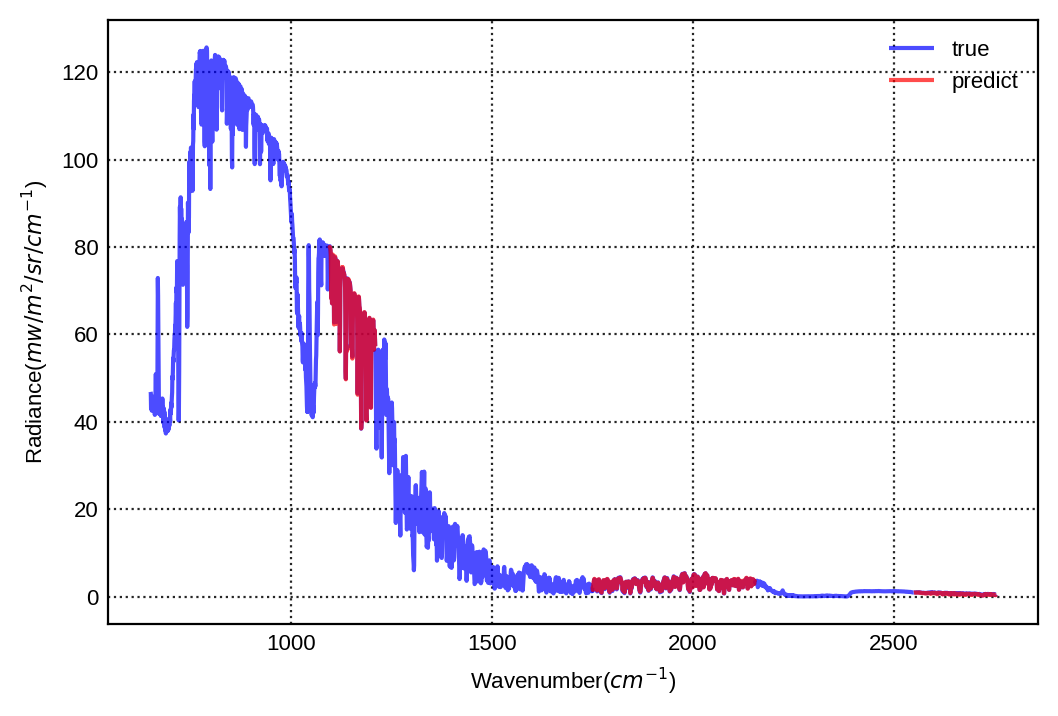

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0003_00.png


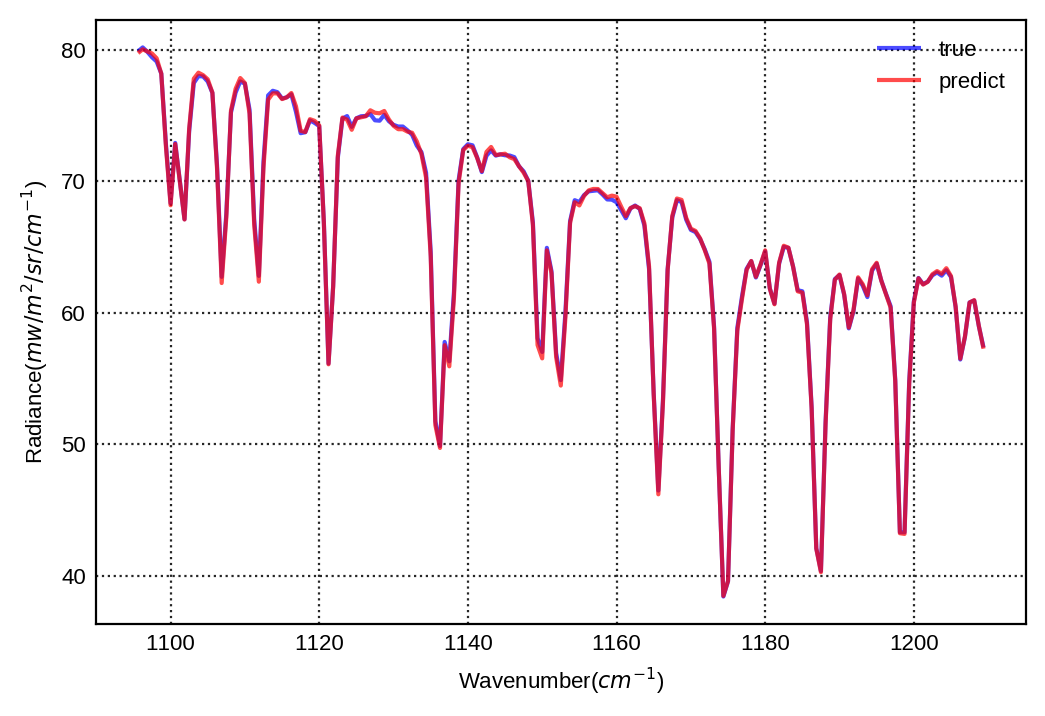

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0003_01.png


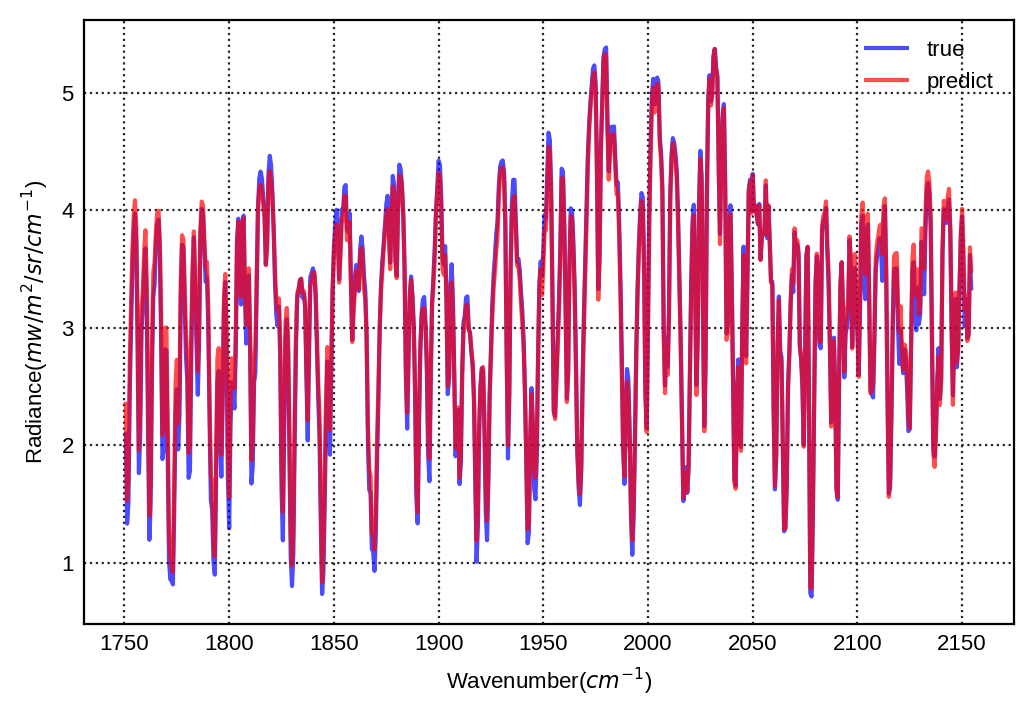

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0003_02.png


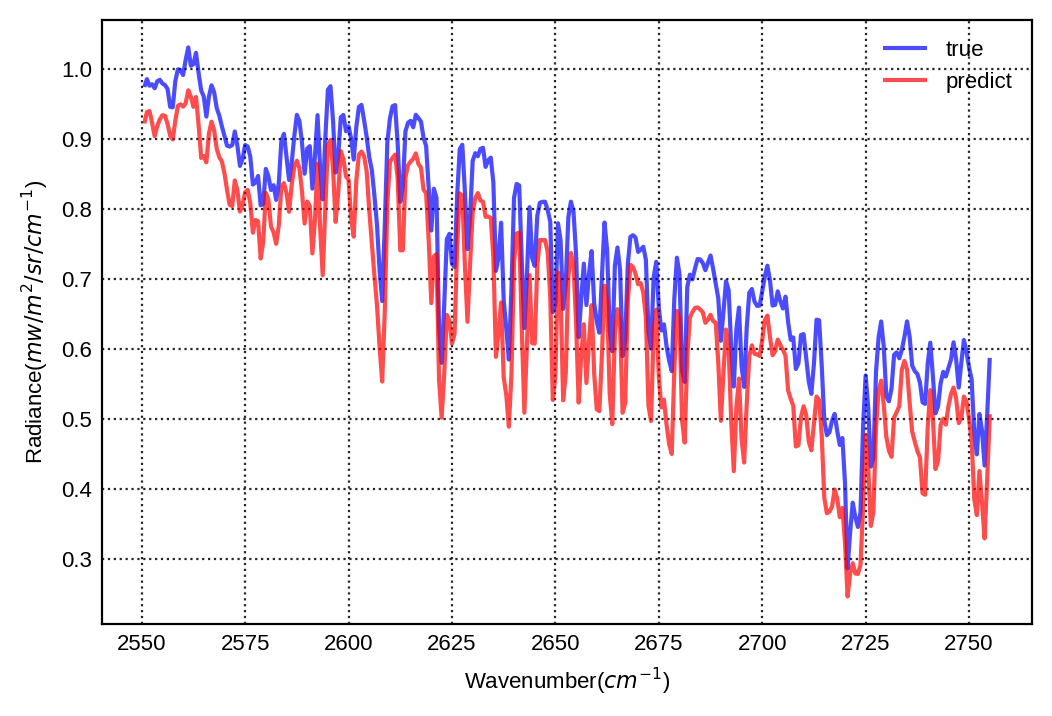

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0003_03.png


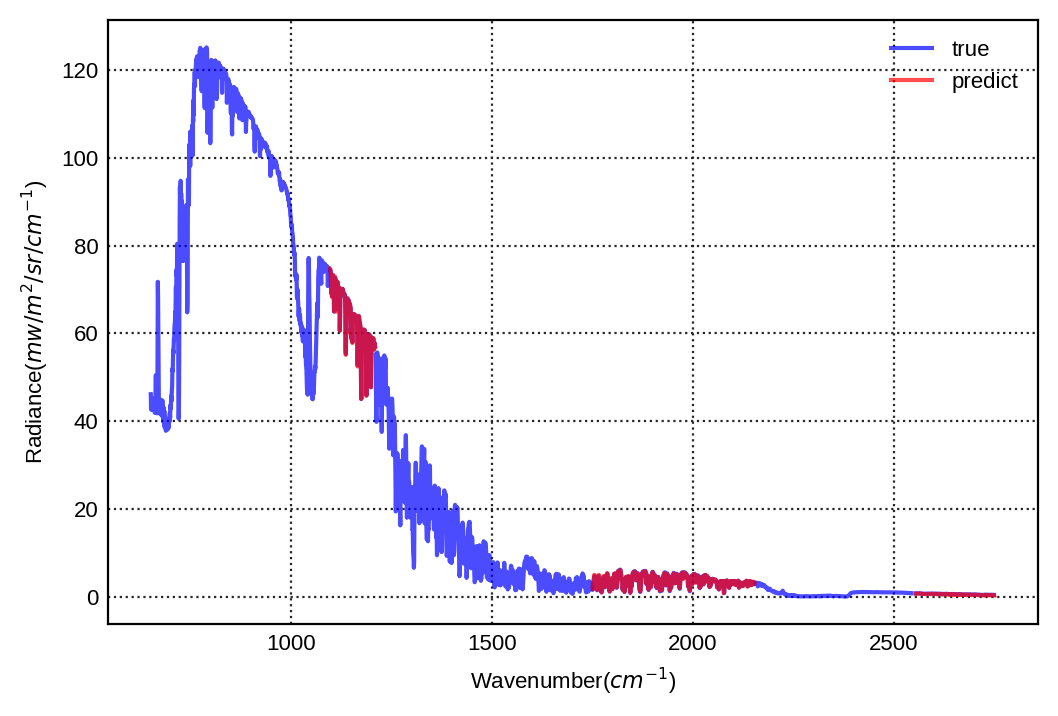

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0004_00.png


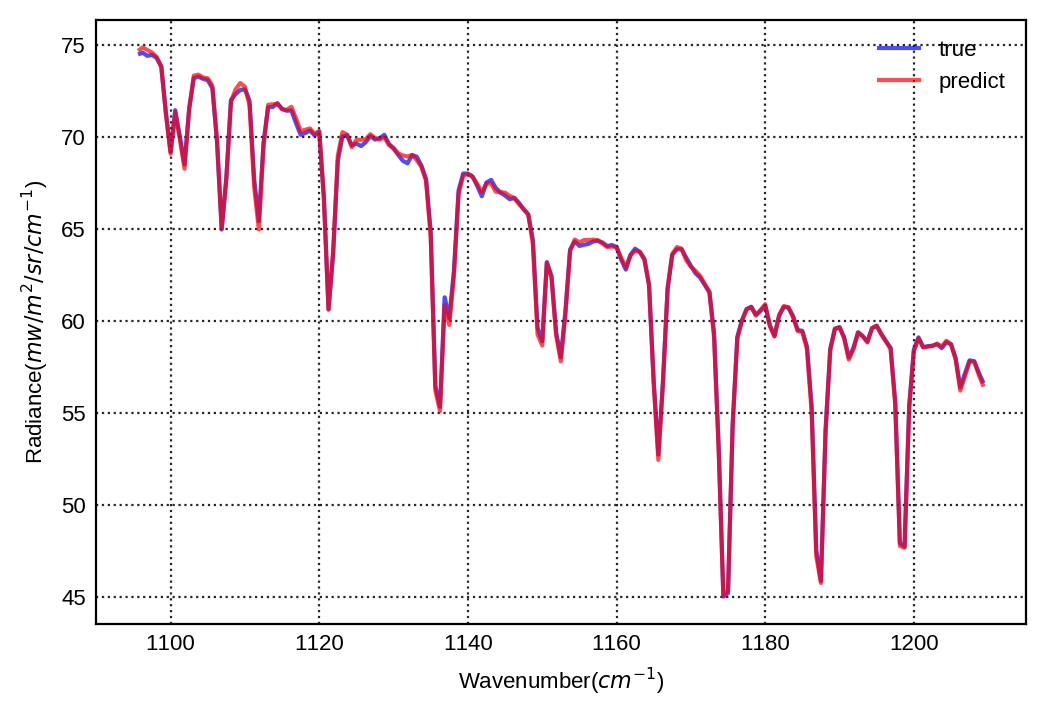

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0004_01.png


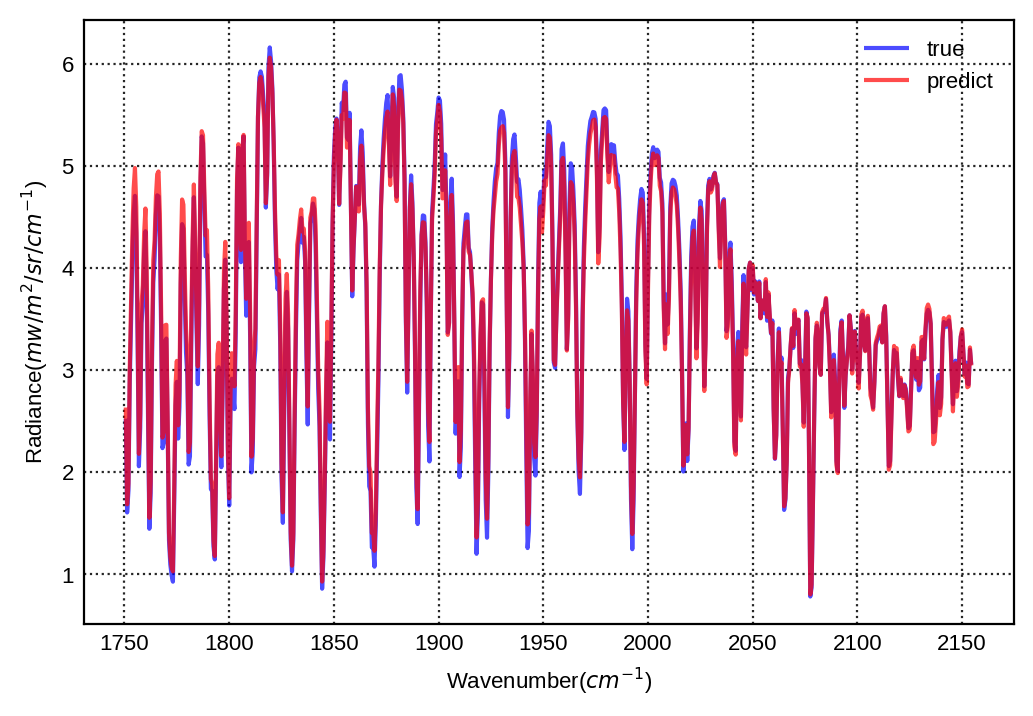

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0004_02.png


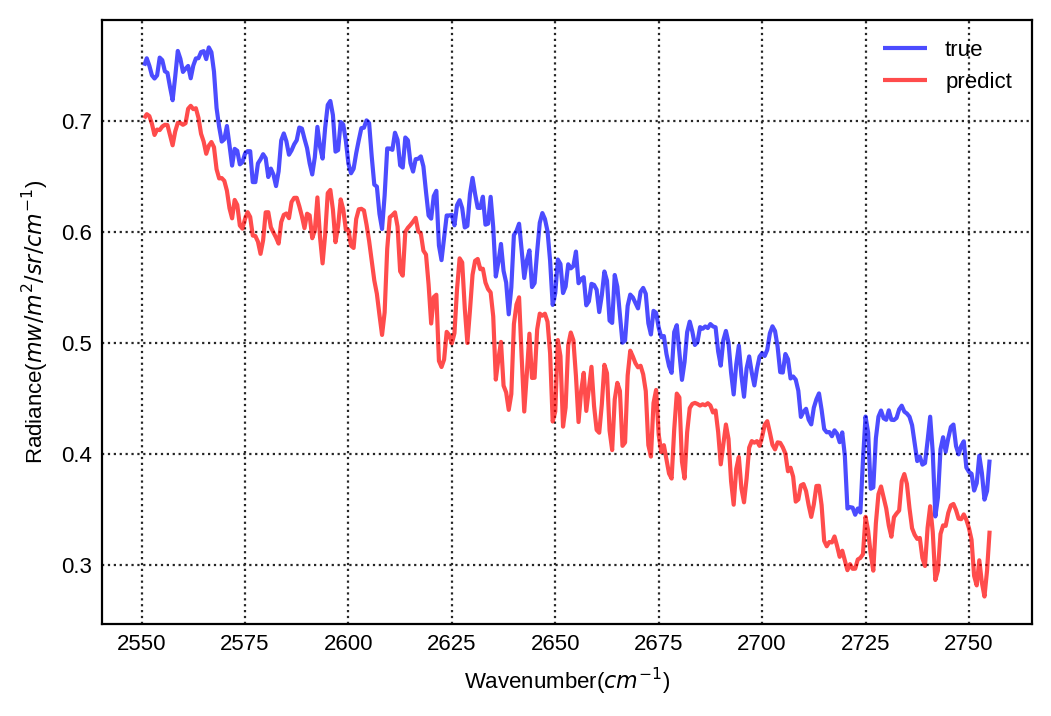

Result/650.0_1095.0_1210.0_1750.0_2155.0_2550.0_1095.625_1209.375_1750.625_2154.375_2550.625_2755.0_dnn/s_0004_03.png


In [82]:
alpha = 0.7

result_dir = 'Result/' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + "_dnn"
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

file_name = result_dir + '/s_{:04d}_{:02d}.png'

for data_number in range(0, 5):
    count = 0
    fig = plt.figure(dpi=200)
    plot_true_label = False
    plot_predict_label = False
    for s, e in index_X:
        plt.plot(wavenumber_X[s: e], test_X[data_number][s: e], c='b', alpha=alpha)
    for s, e in index_Y:
        if plot_true_label:
            label=None
        else:
            label='true'
        plt.plot(wavenumber_Y[s: e], test_Y[data_number][s: e], c='b', alpha=alpha, label=label)
        plot_true_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict'
        plt.plot(wavenumber_Y[s: e], predict_Y_dnn[data_number][s: e], c='r', alpha=alpha, label=label)
        plot_predict_label = True
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('Radiance($mw/m^2/sr/cm^{-1}$)')
    plt.legend()
    plt.show()
    fig.savefig(file_name.format(data_number, count), dpi=200)
    print(file_name.format(data_number, count))
    count += 1
    for s, e in index_Y:
        fig = plt.figure(dpi=200)
        plt.plot(wavenumber_Y[s: e], test_Y[data_number][s: e], c='b', alpha=alpha, label='true')
        plt.plot(wavenumber_Y[s: e], predict_Y_dnn[data_number][s: e], c='r', alpha=alpha, label='predict')
        plt.xlabel('Wavenumber($cm^{-1}$)')
        plt.ylabel('Radiance($mw/m^2/sr/cm^{-1}$)')
        plt.legend()
        plt.show()
        fig.savefig(file_name.format(data_number, count), dpi=200)
        print(file_name.format(data_number, count))
        count += 1